### IMPORT NECESSARY LIBRARIES 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [5]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [58]:
df = pd.read_csv('all_stocks_5yr.csv')
df.head(3)

,date,close,Name
0,2/8/2013,14.7500,AAL
1,2/11/2013,14.4600,AAL
2,2/12/2013,14.2700,AAL


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   close   619040 non-null  float64
 2   Name    619040 non-null  object 
dtypes: float64(1), object(2)
memory usage: 14.2+ MB


In [9]:
# convert date column into 'date' format
df.date = pd.to_datetime(df.date)

### BEFORE AUTOMATION  - TRAIN AN LSTM MODEL WITH A SINGLE RANDOMLY CHOSEN STOCK -

In [365]:
#Randomly choose a stock to train the model - let's select 'ADBE'
df1 = df[df['Name']== 'ADBE']

In [366]:
df2 = df1.drop(columns=['Name'])

In [367]:
df2 = df2.set_index('date')
df2.tail(3)

,close
date,
2018-02-05,190.2700
2018-02-06,194.4700
2018-02-07,192.3400


In [18]:
# Create a function to generate dataset for LSTM model
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [369]:
# Prepare the data before establishing the model
dataset = df2.close.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  
look_back = 10
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [370]:
# Establish the model
model = Sequential()
model.add(LSTM(64,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=500, batch_size=30, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20)], verbose=1)


Train on 996 samples, validate on 241 samples
Epoch 1/500
996/996 [==============================] - 1s 765us/step - loss: 0.0144 - val_loss: 0.0019
Epoch 2/500
996/996 [==============================] - 0s 97us/step - loss: 0.0016 - val_loss: 0.0090
Epoch 3/500
996/996 [==============================] - 0s 90us/step - loss: 0.0011 - val_loss: 0.0032
Epoch 4/500
996/996 [==============================] - 0s 105us/step - loss: 8.5222e-04 - val_loss: 9.3678e-04
Epoch 5/500
996/996 [==============================] - 0s 108us/step - loss: 8.5840e-04 - val_loss: 7.2165e-04
Epoch 6/500
996/996 [==============================] - 0s 109us/step - loss: 7.1530e-04 - val_loss: 7.9027e-04
Epoch 7/500
996/996 [==============================] - 0s 94us/step - loss: 6.3227e-04 - val_loss: 9.0247e-04
Epoch 8/500
996/996 [==============================] - 0s 95us/step - loss: 6.0372e-04 - val_loss: 8.3951e-04
Epoch 9/500
996/996 [==============================] - 0s 113us/step - loss: 5.7974e-04 - val_

996/996 [==============================] - 0s 89us/step - loss: 1.2424e-04 - val_loss: 7.3644e-04
Epoch 148/500
996/996 [==============================] - 0s 90us/step - loss: 1.3817e-04 - val_loss: 2.3377e-04
Epoch 149/500
996/996 [==============================] - 0s 90us/step - loss: 1.3872e-04 - val_loss: 3.9363e-04
Epoch 150/500
996/996 [==============================] - 0s 88us/step - loss: 1.2258e-04 - val_loss: 3.5790e-04
Epoch 151/500
996/996 [==============================] - 0s 86us/step - loss: 1.3564e-04 - val_loss: 2.3097e-04
Epoch 152/500
996/996 [==============================] - 0s 86us/step - loss: 1.3744e-04 - val_loss: 8.7518e-04
Epoch 153/500
996/996 [==============================] - 0s 87us/step - loss: 1.3609e-04 - val_loss: 2.4586e-04
Epoch 154/500
996/996 [==============================] - 0s 88us/step - loss: 1.2713e-04 - val_loss: 4.2043e-04
Epoch 155/500
996/996 [==============================] - 0s 87us/step - loss: 1.2745e-04 - val_loss: 9.5882e-04
Epoch 

In [371]:
# Prediction Results
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform(Y_train.reshape(-1,1))
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[0])))

Train Mean Absolute Error: 0.5597458
Train Root Mean Squared Error: 0.5597458
Test Mean Absolute Error: 1.5848694
Test Root Mean Squared Error: 1.5848694


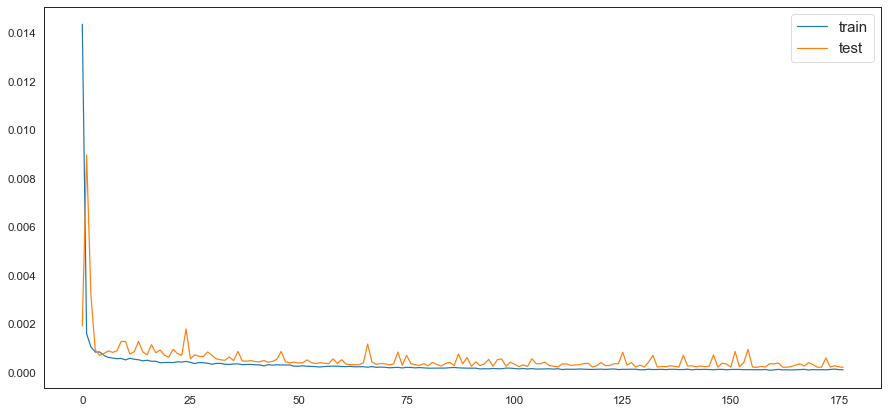

In [372]:
# TRAIN-TEST ERROR ASSESSMENT (It seems model starts to balance its accuracy after ~30th epoch)
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend(fontsize=15)

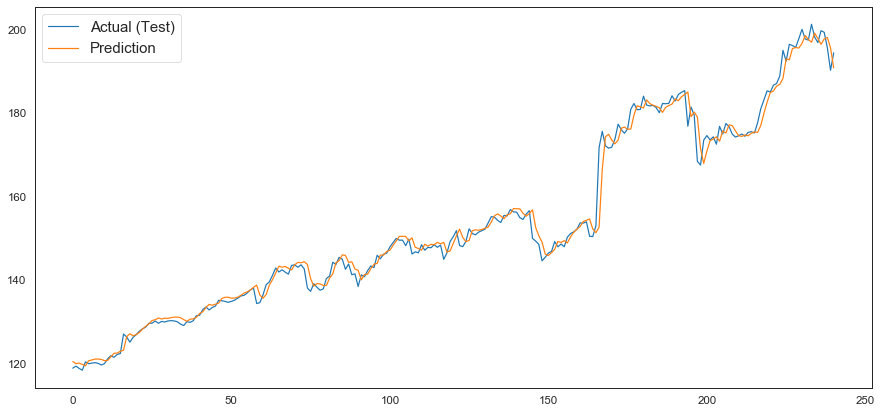

In [373]:
# GRAPH CREATION (test vs trained model) - It seems there is a great fit!
test_actual = pd.DataFrame(Y_test)
test_actual = test_actual.rename(columns={0: 'Actual'})
test_prediction = pd.DataFrame(test_predict)
test_prediction = test_prediction.rename(columns={0: 'Prediction'})
graph =  pd.concat([test_actual, test_prediction], axis=1, sort=False)
# SETTINGS
plt.figure(figsize=(15,7))
plt.plot(graph.Actual,label="Actual (Test)")
plt.plot(graph.Prediction,label="Prediction")
plt.legend(fontsize=15)

In [273]:
### EXAMPLE - HOW TO PREDICT FUTURE? (NEXT 1 DAY)
new = df2.iloc[-look_back:,:]
data_new = scaler.fit_transform(new)
data_new = np.array(data_new)

xyz = np.reshape(data_new, (1, 1, look_back))
xyz = model.predict_on_batch(xyz)
future_prediction = scaler.inverse_transform(xyz)
print(scaler.inverse_transform(data_new)),print(future_prediction)

[[197.51]
 [201.3 ]
 [198.23]
 [196.9 ]
 [199.76]
 [199.38]
 [195.64]
 [190.27]
 [194.47]
 [192.34]]
[[194.24176]]


(None, None)

### AUTOMATION

In [38]:
# AUTOMATION (adjustment 1)

# PERIOD SELECTION FOR TESTS ( let's go ahead with a 2-year data)
# A randomly chosen time frame
start_date = '2015-10-06'
before_prediction_date = '2017-07-06'     # must be same #
target_prediction_day = '2017-07-07'

period_ends = before_prediction_date          # must be same #
prediod_begins = '2017-06-22'

In [39]:
# Data filtering based on the selected date interval
df2 = df[(df.date >= start_date) & (df.date <= target_prediction_day)]
count_of_train_days = df2['date'].nunique()
count_of_train_days

442

In [40]:
# AUTOMATION (adjustment 2)
# This will be a 1 day forward prediction 
train_day_count = count_of_train_days -1
predict_day_count = 1 

In [41]:
# Data Manipulation to 
df3 = df2.pivot(index='date',columns = 'Name', values = 'close')
NAColumns = df3.columns[df3.isna().any()].tolist()
df3 = df3.drop(NAColumns,axis=1)
stock_count = len(df3.columns)
stock_count

491

In [42]:
# PERIOD CHECK (THIS MUST BE EQUAL TO LOOK BACK)
print(df3.loc[prediod_begins:period_ends,:].iloc[:,0])  # only first column 
print(len(df3.loc[prediod_begins:period_ends,]))

date
2017-06-22   60.6100
2017-06-23   59.7700
2017-06-26   59.2400
2017-06-27   58.8800
2017-06-28   59.4000
2017-06-29   58.8000
2017-06-30   59.3100
2017-07-03   59.1300
2017-07-05   59.7700
2017-07-06   59.2200
Name: A, dtype: float64
10


In [43]:
# choose as much stock as you want (lets go ahead with 50 randomly chosen stocks)
df3 = df3.iloc[:,250:300]
df3.tail(3)

Name,JNPR,JPM,JWN,K,KEY,KHC,KIM,KLAC,KMB,KMI,...,MCHP,MCK,MCO,MDLZ,MDT,MET,MGM,MHK,MKC,MLM
date,,,,,,,,,,,,,,,,,,,,,
2017-07-05,28.1800,93.6800,48.1200,67.7000,19.2000,83.7900,17.8500,92.2900,128.6600,19.3100,...,77.9400,165.2700,123.9800,43.1200,88.9000,55.8900,30.9800,243.7600,96.7500,226.8400
2017-07-06,27.7900,93.3800,47.3800,66.5500,19.0000,82.8200,17.9600,92.4800,126.3800,19.1300,...,77.1200,163.0800,122.1700,43.0600,87.2600,55.8800,30.3000,241.6700,95.7400,226.0000
2017-07-07,28.4500,93.8500,47.5400,66.5200,19.2200,83.0400,18.4300,94.5700,126.8000,19.1700,...,78.3600,164.6800,123.4200,43.2200,87.9600,56.1700,30.8400,245.7500,95.7500,227.9000


In [44]:
### FOR LOOP TO POPULATE PREDICTIONS FOR EACH STOCK ###

a = []
upper = len(df3.columns)
for x in range(0,upper):
    
    
    # DATA PREPARATION PHASE
    df6  = pd.DataFrame(df3.iloc[:,x]) ### dataset  = pd.DataFrame(df3.iloc[:,x])
    dataset = df6.iloc[0:train_day_count,:].values ### dataset = dataset1.iloc[:,0].values#numpy.ndarray 
    dataset = dataset.astype('float32')
    dataset = np.reshape(dataset, (-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    train_size = int(len(dataset) * 0.80)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    
    # create datasets for model  
    look_back = 10
    X_train, Y_train = create_dataset(train, look_back)
    X_test, Y_test = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    # MODEL PHASE
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    history = model.fit(X_train, Y_train, epochs=500, batch_size=30, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20)], verbose=1)
    model.summary()
    
    ### PREDICTION    --- To predict future NEXT 1 DAY) --- new = dataset.iloc[-look_back:,:]
    new = df6.loc[prediod_begins:period_ends,:]
    data_new = scaler.fit_transform(new)
    data_new = np.array(data_new)

    xyz = np.reshape(data_new, (1, 1, look_back))
    xyz = model.predict_on_batch(xyz)
    future_prediction = scaler.inverse_transform(xyz)
    
    ### POPULATING RESULTS
    a.append(future_prediction)

Train on 341 samples, validate on 78 samples
Epoch 1/500
341/341 [==============================] - 1s 2ms/step - loss: 0.1473 - val_loss: 0.1721
Epoch 2/500
341/341 [==============================] - 0s 82us/step - loss: 0.0417 - val_loss: 0.0235
Epoch 3/500
341/341 [==============================] - 0s 91us/step - loss: 0.0107 - val_loss: 0.0046
Epoch 4/500
341/341 [==============================] - 0s 91us/step - loss: 0.0114 - val_loss: 0.0042
Epoch 5/500
341/341 [==============================] - 0s 88us/step - loss: 0.0092 - val_loss: 0.0066
Epoch 6/500
341/341 [==============================] - 0s 85us/step - loss: 0.0089 - val_loss: 0.0069
Epoch 7/500
341/341 [==============================] - 0s 88us/step - loss: 0.0084 - val_loss: 0.0059
Epoch 8/500
341/341 [==============================] - 0s 79us/step - loss: 0.0077 - val_loss: 0.0047
Epoch 9/500
341/341 [==============================] - 0s 94us/step - loss: 0.0075 - val_loss: 0.0046
Epoch 10/500
341/341 [================

Epoch 80/500
341/341 [==============================] - 0s 91us/step - loss: 0.0036 - val_loss: 0.0016
Epoch 81/500
341/341 [==============================] - 0s 85us/step - loss: 0.0034 - val_loss: 0.0015
Epoch 82/500
341/341 [==============================] - 0s 85us/step - loss: 0.0035 - val_loss: 0.0018
Epoch 83/500
341/341 [==============================] - 0s 91us/step - loss: 0.0037 - val_loss: 0.0016
Epoch 84/500
341/341 [==============================] - 0s 97us/step - loss: 0.0032 - val_loss: 0.0013
Epoch 85/500
341/341 [==============================] - 0s 91us/step - loss: 0.0040 - val_loss: 0.0013
Epoch 86/500
341/341 [==============================] - 0s 88us/step - loss: 0.0033 - val_loss: 0.0013
Epoch 87/500
341/341 [==============================] - 0s 91us/step - loss: 0.0035 - val_loss: 0.0015
Epoch 88/500
341/341 [==============================] - 0s 88us/step - loss: 0.0033 - val_loss: 0.0015
Epoch 89/500
341/341 [==============================] - 0s 85us/step - lo

Epoch 159/500
341/341 [==============================] - 0s 88us/step - loss: 0.0031 - val_loss: 0.0016
Epoch 160/500
341/341 [==============================] - 0s 88us/step - loss: 0.0031 - val_loss: 0.0011
Epoch 161/500
341/341 [==============================] - 0s 91us/step - loss: 0.0031 - val_loss: 0.0013
Epoch 162/500
341/341 [==============================] - 0s 94us/step - loss: 0.0029 - val_loss: 0.0011
Epoch 163/500
341/341 [==============================] - 0s 94us/step - loss: 0.0028 - val_loss: 0.0011
Epoch 164/500
341/341 [==============================] - 0s 100us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 165/500
341/341 [==============================] - 0s 94us/step - loss: 0.0028 - val_loss: 0.0012
Epoch 166/500
341/341 [==============================] - 0s 106us/step - loss: 0.0026 - val_loss: 0.0011
Epoch 167/500
341/341 [==============================] - 0s 100us/step - loss: 0.0030 - val_loss: 0.0011
Epoch 168/500
341/341 [==============================] - 0s 9

341/341 [==============================] - 0s 94us/step - loss: 0.0034 - val_loss: 0.0022
Epoch 10/500
341/341 [==============================] - 0s 106us/step - loss: 0.0037 - val_loss: 0.0024
Epoch 11/500
341/341 [==============================] - 0s 85us/step - loss: 0.0038 - val_loss: 0.0028
Epoch 12/500
341/341 [==============================] - 0s 114us/step - loss: 0.0035 - val_loss: 0.0028
Epoch 13/500
341/341 [==============================] - 0s 119us/step - loss: 0.0037 - val_loss: 0.0028
Epoch 14/500
341/341 [==============================] - 0s 100us/step - loss: 0.0038 - val_loss: 0.0032
Epoch 15/500
341/341 [==============================] - 0s 108us/step - loss: 0.0036 - val_loss: 0.0028
Epoch 16/500
341/341 [==============================] - 0s 114us/step - loss: 0.0033 - val_loss: 0.0022
Epoch 17/500
341/341 [==============================] - 0s 94us/step - loss: 0.0038 - val_loss: 0.0036
Epoch 18/500
341/341 [==============================] - 0s 111us/step - loss: 0.

341/341 [==============================] - 0s 79us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 89/500
341/341 [==============================] - 0s 76us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 90/500
341/341 [==============================] - 0s 75us/step - loss: 0.0015 - val_loss: 9.1699e-04
Epoch 91/500
341/341 [==============================] - 0s 76us/step - loss: 0.0015 - val_loss: 8.9699e-04
Epoch 92/500
341/341 [==============================] - 0s 76us/step - loss: 0.0015 - val_loss: 9.8290e-04
Epoch 93/500
341/341 [==============================] - 0s 79us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 94/500
341/341 [==============================] - 0s 85us/step - loss: 0.0016 - val_loss: 0.0021
Epoch 95/500
341/341 [==============================] - 0s 88us/step - loss: 0.0016 - val_loss: 8.9502e-04
Epoch 96/500
341/341 [==============================] - 0s 82us/step - loss: 0.0019 - val_loss: 0.0011
Epoch 97/500
341/341 [==============================] - 0s 79us/step -

Epoch 165/500
341/341 [==============================] - 0s 82us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 166/500
341/341 [==============================] - 0s 76us/step - loss: 0.0013 - val_loss: 8.8595e-04
Epoch 167/500
341/341 [==============================] - 0s 82us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 168/500
341/341 [==============================] - 0s 79us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 169/500
341/341 [==============================] - 0s 79us/step - loss: 0.0015 - val_loss: 7.4046e-04
Epoch 170/500
341/341 [==============================] - 0s 82us/step - loss: 0.0015 - val_loss: 7.3428e-04
Epoch 171/500
341/341 [==============================] - 0s 82us/step - loss: 0.0013 - val_loss: 9.2714e-04
Epoch 172/500
341/341 [==============================] - 0s 79us/step - loss: 0.0015 - val_loss: 8.4202e-04
Epoch 173/500
341/341 [==============================] - 0s 76us/step - loss: 0.0012 - val_loss: 7.4611e-04
Epoch 174/500
341/341 [=================

341/341 [==============================] - 0s 79us/step - loss: 0.0010 - val_loss: 8.0631e-04
Epoch 242/500
341/341 [==============================] - 0s 76us/step - loss: 0.0012 - val_loss: 7.8835e-04
Epoch 243/500
341/341 [==============================] - 0s 79us/step - loss: 9.5975e-04 - val_loss: 9.7075e-04
Epoch 244/500
341/341 [==============================] - 0s 79us/step - loss: 0.0013 - val_loss: 0.0019
Epoch 245/500
341/341 [==============================] - 0s 76us/step - loss: 0.0011 - val_loss: 7.2769e-04
Epoch 246/500
341/341 [==============================] - 0s 76us/step - loss: 0.0013 - val_loss: 6.5395e-04
Epoch 247/500
341/341 [==============================] - 0s 79us/step - loss: 9.8795e-04 - val_loss: 7.6632e-04
Epoch 248/500
341/341 [==============================] - 0s 103us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 249/500
341/341 [==============================] - 0s 114us/step - loss: 0.0012 - val_loss: 8.5830e-04
Epoch 250/500
341/341 [=================

341/341 [==============================] - 0s 88us/step - loss: 0.0012 - val_loss: 9.2117e-04
Epoch 317/500
341/341 [==============================] - 0s 73us/step - loss: 9.7285e-04 - val_loss: 5.9534e-04
Epoch 318/500
341/341 [==============================] - 0s 78us/step - loss: 0.0011 - val_loss: 6.3406e-04
Epoch 319/500
341/341 [==============================] - 0s 79us/step - loss: 9.5226e-04 - val_loss: 0.0017
Epoch 320/500
341/341 [==============================] - 0s 82us/step - loss: 0.0011 - val_loss: 6.7250e-04
Epoch 321/500
341/341 [==============================] - 0s 85us/step - loss: 0.0010 - val_loss: 5.9266e-04
Epoch 322/500
341/341 [==============================] - 0s 82us/step - loss: 8.5056e-04 - val_loss: 7.8586e-04
Epoch 323/500
341/341 [==============================] - 0s 85us/step - loss: 0.0012 - val_loss: 7.0584e-04
Epoch 324/500
341/341 [==============================] - 0s 82us/step - loss: 8.8961e-04 - val_loss: 6.1539e-04
Epoch 325/500
341/341 [=======

Epoch 38/500
341/341 [==============================] - 0s 79us/step - loss: 0.0031 - val_loss: 0.0021
Epoch 39/500
341/341 [==============================] - 0s 73us/step - loss: 0.0030 - val_loss: 0.0021
Epoch 40/500
341/341 [==============================] - 0s 76us/step - loss: 0.0030 - val_loss: 0.0021
Epoch 41/500
341/341 [==============================] - 0s 76us/step - loss: 0.0032 - val_loss: 0.0021
Epoch 42/500
341/341 [==============================] - 0s 76us/step - loss: 0.0030 - val_loss: 0.0020
Epoch 43/500
341/341 [==============================] - 0s 79us/step - loss: 0.0028 - val_loss: 0.0021
Epoch 44/500
341/341 [==============================] - 0s 79us/step - loss: 0.0028 - val_loss: 0.0020
Epoch 45/500
341/341 [==============================] - 0s 88us/step - loss: 0.0030 - val_loss: 0.0020
Epoch 46/500
341/341 [==============================] - 0s 76us/step - loss: 0.0030 - val_loss: 0.0019
Epoch 47/500
341/341 [==============================] - 0s 82us/step - lo

341/341 [==============================] - 0s 82us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 118/500
341/341 [==============================] - 0s 79us/step - loss: 0.0020 - val_loss: 0.0014
Epoch 119/500
341/341 [==============================] - 0s 79us/step - loss: 0.0022 - val_loss: 0.0015
Epoch 120/500
341/341 [==============================] - 0s 79us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 121/500
341/341 [==============================] - 0s 79us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 122/500
341/341 [==============================] - 0s 79us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 123/500
341/341 [==============================] - 0s 79us/step - loss: 0.0021 - val_loss: 0.0014
Epoch 124/500
341/341 [==============================] - 0s 82us/step - loss: 0.0021 - val_loss: 0.0014
Epoch 125/500
341/341 [==============================] - 0s 76us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 126/500
341/341 [==============================] - 0s 81us/step - loss: 

341/341 [==============================] - 0s 88us/step - loss: 0.0018 - val_loss: 0.0012
Epoch 196/500
341/341 [==============================] - 0s 76us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 197/500
341/341 [==============================] - 0s 82us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 198/500
341/341 [==============================] - 0s 85us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 199/500
341/341 [==============================] - 0s 85us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 200/500
341/341 [==============================] - 0s 79us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 201/500
341/341 [==============================] - 0s 76us/step - loss: 0.0018 - val_loss: 0.0012
Epoch 202/500
341/341 [==============================] - 0s 82us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 203/500
341/341 [==============================] - 0s 82us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 204/500
341/341 [==============================] - 0s 76us/step - loss: 

341/341 [==============================] - 0s 79us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 274/500
341/341 [==============================] - 0s 82us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 275/500
341/341 [==============================] - 0s 76us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 276/500
341/341 [==============================] - 0s 81us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 277/500
341/341 [==============================] - 0s 82us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 278/500
341/341 [==============================] - 0s 317us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 279/500
341/341 [==============================] - 0s 100us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 280/500
341/341 [==============================] - 0s 91us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 281/500
341/341 [==============================] - 0s 91us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 282/500
341/341 [==============================] - 0s 117us/step - los

341/341 [==============================] - 0s 79us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 352/500
341/341 [==============================] - 0s 91us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 353/500
341/341 [==============================] - 0s 116us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 354/500
341/341 [==============================] - 0s 114us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 355/500
341/341 [==============================] - 0s 91us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 356/500
341/341 [==============================] - 0s 82us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 357/500
341/341 [==============================] - 0s 97us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 358/500
341/341 [==============================] - 0s 91us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 359/500
341/341 [==============================] - 0s 88us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 360/500
341/341 [==============================] - 0s 85us/step - loss

341/341 [==============================] - 0s 89us/step - loss: 0.0048 - val_loss: 0.0026
Epoch 32/500
341/341 [==============================] - 0s 97us/step - loss: 0.0043 - val_loss: 0.0028
Epoch 33/500
341/341 [==============================] - 0s 103us/step - loss: 0.0040 - val_loss: 0.0032
Epoch 34/500
341/341 [==============================] - 0s 182us/step - loss: 0.0046 - val_loss: 0.0024
Epoch 35/500
341/341 [==============================] - 0s 123us/step - loss: 0.0052 - val_loss: 0.0026
Epoch 36/500
341/341 [==============================] - 0s 279us/step - loss: 0.0051 - val_loss: 0.0024
Epoch 37/500
341/341 [==============================] - 0s 132us/step - loss: 0.0046 - val_loss: 0.0025
Epoch 38/500
341/341 [==============================] - 0s 152us/step - loss: 0.0054 - val_loss: 0.0024
Epoch 39/500
341/341 [==============================] - 0s 390us/step - loss: 0.0045 - val_loss: 0.0025
Epoch 40/500
341/341 [==============================] - 0s 179us/step - loss: 0

341/341 [==============================] - 0s 85us/step - loss: 0.0030 - val_loss: 0.0014
Epoch 110/500
341/341 [==============================] - 0s 88us/step - loss: 0.0027 - val_loss: 0.0016
Epoch 111/500
341/341 [==============================] - 0s 82us/step - loss: 0.0031 - val_loss: 0.0012
Epoch 112/500
341/341 [==============================] - 0s 76us/step - loss: 0.0030 - val_loss: 0.0013
Epoch 113/500
341/341 [==============================] - 0s 82us/step - loss: 0.0029 - val_loss: 0.0012
Epoch 114/500
341/341 [==============================] - 0s 85us/step - loss: 0.0028 - val_loss: 0.0012
Epoch 115/500
341/341 [==============================] - 0s 82us/step - loss: 0.0030 - val_loss: 0.0016
Epoch 116/500
341/341 [==============================] - 0s 79us/step - loss: 0.0029 - val_loss: 0.0014
Epoch 117/500
341/341 [==============================] - 0s 76us/step - loss: 0.0028 - val_loss: 0.0013
Epoch 118/500
341/341 [==============================] - 0s 79us/step - loss: 

341/341 [==============================] - 0s 94us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 61/500
341/341 [==============================] - 0s 82us/step - loss: 0.0026 - val_loss: 0.0020
Epoch 62/500
341/341 [==============================] - 0s 85us/step - loss: 0.0028 - val_loss: 0.0019
Epoch 63/500
341/341 [==============================] - 0s 79us/step - loss: 0.0023 - val_loss: 0.0019
Epoch 64/500
341/341 [==============================] - 0s 82us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 65/500
341/341 [==============================] - 0s 82us/step - loss: 0.0024 - val_loss: 0.0019
Epoch 66/500
341/341 [==============================] - 0s 76us/step - loss: 0.0023 - val_loss: 0.0018
Epoch 67/500
341/341 [==============================] - 0s 79us/step - loss: 0.0026 - val_loss: 0.0018
Epoch 68/500
341/341 [==============================] - 0s 79us/step - loss: 0.0022 - val_loss: 0.0018
Epoch 69/500
341/341 [==============================] - 0s 85us/step - loss: 0.0025 - 

Epoch 139/500
341/341 [==============================] - 0s 100us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 140/500
341/341 [==============================] - 0s 103us/step - loss: 0.0016 - val_loss: 0.0023
Epoch 141/500
341/341 [==============================] - 0s 103us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 142/500
341/341 [==============================] - 0s 103us/step - loss: 0.0019 - val_loss: 0.0019
Epoch 143/500
341/341 [==============================] - 0s 94us/step - loss: 0.0016 - val_loss: 0.0022
Epoch 144/500
341/341 [==============================] - 0s 106us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 145/500
341/341 [==============================] - 0s 100us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 146/500
341/341 [==============================] - 0s 97us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 147/500
341/341 [==============================] - 0s 82us/step - loss: 0.0014 - val_loss: 0.0025
Epoch 148/500
341/341 [==============================] - 0

341/341 [==============================] - 0s 79us/step - loss: 0.0018 - val_loss: 0.0012
Epoch 218/500
341/341 [==============================] - 0s 79us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 219/500
341/341 [==============================] - 0s 82us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 220/500
341/341 [==============================] - 0s 79us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 221/500
341/341 [==============================] - 0s 79us/step - loss: 0.0015 - val_loss: 0.0019
Epoch 222/500
341/341 [==============================] - 0s 76us/step - loss: 0.0015 - val_loss: 0.0015
Epoch 223/500
341/341 [==============================] - 0s 82us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 224/500
341/341 [==============================] - 0s 85us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 225/500
341/341 [==============================] - 0s 79us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 226/500
341/341 [==============================] - 0s 79us/step - loss: 

341/341 [==============================] - 0s 82us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 296/500
341/341 [==============================] - 0s 79us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 297/500
341/341 [==============================] - 0s 79us/step - loss: 0.0014 - val_loss: 0.0010
Epoch 298/500
341/341 [==============================] - 0s 97us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 299/500
341/341 [==============================] - 0s 111us/step - loss: 0.0013 - val_loss: 0.0010
Epoch 300/500
341/341 [==============================] - 0s 117us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 301/500
341/341 [==============================] - 0s 114us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 302/500
341/341 [==============================] - 0s 103us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 303/500
341/341 [==============================] - 0s 109us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 304/500
341/341 [==============================] - 0s 97us/step - l

341/341 [==============================] - 0s 82us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 374/500
341/341 [==============================] - 0s 82us/step - loss: 9.4819e-04 - val_loss: 0.0014
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 64)                19200     
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
_________________________________________________________________
Train on 341 samples, validate on 78 samples
Epoch 1/500
341/341 [==============================] - 0s 1ms/step - loss: 0.1836 - val_loss: 0.1961
Epoch 2/500
341/341 [==============

Epoch 71/500
341/341 [==============================] - 0s 97us/step - loss: 0.0036 - val_loss: 8.9149e-04
Epoch 72/500
341/341 [==============================] - 0s 79us/step - loss: 0.0038 - val_loss: 9.2633e-04
Epoch 73/500
341/341 [==============================] - 0s 79us/step - loss: 0.0039 - val_loss: 9.0556e-04
Epoch 74/500
341/341 [==============================] - 0s 79us/step - loss: 0.0036 - val_loss: 0.0015
Epoch 75/500
341/341 [==============================] - 0s 79us/step - loss: 0.0034 - val_loss: 8.6440e-04
Epoch 76/500
341/341 [==============================] - 0s 82us/step - loss: 0.0037 - val_loss: 0.0012
Epoch 77/500
341/341 [==============================] - 0s 82us/step - loss: 0.0037 - val_loss: 8.5611e-04
Epoch 78/500
341/341 [==============================] - 0s 82us/step - loss: 0.0036 - val_loss: 0.0023
Epoch 79/500
341/341 [==============================] - 0s 84us/step - loss: 0.0036 - val_loss: 8.2079e-04
Epoch 80/500
341/341 [===========================

341/341 [==============================] - 0s 82us/step - loss: 0.0030 - val_loss: 7.2174e-04
Epoch 148/500
341/341 [==============================] - 0s 82us/step - loss: 0.0032 - val_loss: 7.3988e-04
Epoch 149/500
341/341 [==============================] - 0s 85us/step - loss: 0.0029 - val_loss: 7.3402e-04
Epoch 150/500
341/341 [==============================] - 0s 82us/step - loss: 0.0027 - val_loss: 6.7099e-04
Epoch 151/500
341/341 [==============================] - 0s 79us/step - loss: 0.0029 - val_loss: 0.0016
Epoch 152/500
341/341 [==============================] - 0s 82us/step - loss: 0.0034 - val_loss: 6.7452e-04
Epoch 153/500
341/341 [==============================] - 0s 82us/step - loss: 0.0029 - val_loss: 0.0014
Epoch 154/500
341/341 [==============================] - 0s 79us/step - loss: 0.0030 - val_loss: 8.6330e-04
Epoch 155/500
341/341 [==============================] - 0s 79us/step - loss: 0.0026 - val_loss: 6.8380e-04
Epoch 156/500
341/341 [===========================

341/341 [==============================] - 0s 73us/step - loss: 0.0035 - val_loss: 0.0030
Epoch 4/500
341/341 [==============================] - 0s 79us/step - loss: 0.0041 - val_loss: 0.0025
Epoch 5/500
341/341 [==============================] - 0s 76us/step - loss: 0.0029 - val_loss: 0.0061
Epoch 6/500
341/341 [==============================] - 0s 82us/step - loss: 0.0024 - val_loss: 0.0076
Epoch 7/500
341/341 [==============================] - 0s 82us/step - loss: 0.0025 - val_loss: 0.0039
Epoch 8/500
341/341 [==============================] - 0s 79us/step - loss: 0.0024 - val_loss: 0.0033
Epoch 9/500
341/341 [==============================] - 0s 85us/step - loss: 0.0024 - val_loss: 0.0045
Epoch 10/500
341/341 [==============================] - 0s 85us/step - loss: 0.0024 - val_loss: 0.0039
Epoch 11/500
341/341 [==============================] - 0s 85us/step - loss: 0.0023 - val_loss: 0.0035
Epoch 12/500
341/341 [==============================] - 0s 82us/step - loss: 0.0024 - val_lo

341/341 [==============================] - 0s 82us/step - loss: 0.0098 - val_loss: 0.0030
Epoch 24/500
341/341 [==============================] - 0s 82us/step - loss: 0.0099 - val_loss: 0.0027
Epoch 25/500
341/341 [==============================] - 0s 85us/step - loss: 0.0092 - val_loss: 0.0026
Epoch 26/500
341/341 [==============================] - 0s 82us/step - loss: 0.0094 - val_loss: 0.0026
Epoch 27/500
341/341 [==============================] - 0s 95us/step - loss: 0.0080 - val_loss: 0.0026
Epoch 28/500
341/341 [==============================] - 0s 81us/step - loss: 0.0086 - val_loss: 0.0025
Epoch 29/500
341/341 [==============================] - 0s 82us/step - loss: 0.0078 - val_loss: 0.0024
Epoch 30/500
341/341 [==============================] - 0s 88us/step - loss: 0.0082 - val_loss: 0.0023
Epoch 31/500
341/341 [==============================] - 0s 85us/step - loss: 0.0074 - val_loss: 0.0023
Epoch 32/500
341/341 [==============================] - 0s 94us/step - loss: 0.0071 - 

341/341 [==============================] - 0s 85us/step - loss: 0.0044 - val_loss: 0.0018
Epoch 103/500
341/341 [==============================] - 0s 79us/step - loss: 0.0043 - val_loss: 0.0017
Epoch 104/500
341/341 [==============================] - 0s 103us/step - loss: 0.0041 - val_loss: 0.0016
Epoch 105/500
341/341 [==============================] - 0s 88us/step - loss: 0.0044 - val_loss: 0.0016
Epoch 106/500
341/341 [==============================] - 0s 100us/step - loss: 0.0042 - val_loss: 0.0016
Epoch 107/500
341/341 [==============================] - 0s 88us/step - loss: 0.0041 - val_loss: 0.0015
Epoch 108/500
341/341 [==============================] - 0s 82us/step - loss: 0.0041 - val_loss: 0.0015
Epoch 109/500
341/341 [==============================] - 0s 85us/step - loss: 0.0044 - val_loss: 0.0015
Epoch 110/500
341/341 [==============================] - 0s 82us/step - loss: 0.0040 - val_loss: 0.0015
Epoch 111/500
341/341 [==============================] - 0s 82us/step - loss

Epoch 15/500
341/341 [==============================] - 0s 91us/step - loss: 0.0040 - val_loss: 3.1327e-04
Epoch 16/500
341/341 [==============================] - 0s 79us/step - loss: 0.0034 - val_loss: 3.0172e-04
Epoch 17/500
341/341 [==============================] - 0s 103us/step - loss: 0.0033 - val_loss: 2.8471e-04
Epoch 18/500
341/341 [==============================] - 0s 79us/step - loss: 0.0034 - val_loss: 2.9295e-04
Epoch 19/500
341/341 [==============================] - 0s 100us/step - loss: 0.0033 - val_loss: 2.7342e-04
Epoch 20/500
341/341 [==============================] - 0s 82us/step - loss: 0.0034 - val_loss: 3.1642e-04
Epoch 21/500
341/341 [==============================] - 0s 82us/step - loss: 0.0034 - val_loss: 2.8848e-04
Epoch 22/500
341/341 [==============================] - 0s 82us/step - loss: 0.0030 - val_loss: 2.7704e-04
Epoch 23/500
341/341 [==============================] - 0s 82us/step - loss: 0.0032 - val_loss: 2.8261e-04
Epoch 24/500
341/341 [=============

341/341 [==============================] - 0s 103us/step - loss: 0.0016 - val_loss: 1.5303e-04
Epoch 92/500
341/341 [==============================] - 0s 106us/step - loss: 0.0016 - val_loss: 1.5775e-04
Epoch 93/500
341/341 [==============================] - 0s 94us/step - loss: 0.0015 - val_loss: 1.5059e-04
Epoch 94/500
341/341 [==============================] - 0s 94us/step - loss: 0.0015 - val_loss: 1.4558e-04
Epoch 95/500
341/341 [==============================] - 0s 100us/step - loss: 0.0014 - val_loss: 2.2438e-04
Epoch 96/500
341/341 [==============================] - 0s 85us/step - loss: 0.0016 - val_loss: 2.7639e-04
Epoch 97/500
341/341 [==============================] - 0s 85us/step - loss: 0.0014 - val_loss: 1.5013e-04
Epoch 98/500
341/341 [==============================] - 0s 82us/step - loss: 0.0016 - val_loss: 2.2238e-04
Epoch 99/500
341/341 [==============================] - 0s 94us/step - loss: 0.0015 - val_loss: 1.4583e-04
Epoch 100/500
341/341 [========================

Epoch 167/500
341/341 [==============================] - 0s 82us/step - loss: 0.0014 - val_loss: 1.4667e-04
Epoch 168/500
341/341 [==============================] - 0s 85us/step - loss: 0.0014 - val_loss: 2.2027e-04
Epoch 169/500
341/341 [==============================] - 0s 88us/step - loss: 0.0014 - val_loss: 1.4028e-04
Epoch 170/500
341/341 [==============================] - 0s 88us/step - loss: 0.0012 - val_loss: 1.3534e-04
Epoch 171/500
341/341 [==============================] - 0s 90us/step - loss: 0.0011 - val_loss: 1.6998e-04
Epoch 172/500
341/341 [==============================] - 0s 85us/step - loss: 0.0011 - val_loss: 1.5142e-04
Epoch 173/500
341/341 [==============================] - 0s 85us/step - loss: 0.0012 - val_loss: 1.6130e-04
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 64)                19200     
_______________________

341/341 [==============================] - 0s 120us/step - loss: 0.0039 - val_loss: 0.0021
Epoch 66/500
341/341 [==============================] - 0s 94us/step - loss: 0.0036 - val_loss: 0.0032
Epoch 67/500
341/341 [==============================] - 0s 97us/step - loss: 0.0039 - val_loss: 0.0020
Epoch 68/500
341/341 [==============================] - 0s 91us/step - loss: 0.0036 - val_loss: 0.0023
Epoch 69/500
341/341 [==============================] - 0s 100us/step - loss: 0.0037 - val_loss: 0.0023
Epoch 70/500
341/341 [==============================] - 0s 97us/step - loss: 0.0034 - val_loss: 0.0020
Epoch 71/500
341/341 [==============================] - 0s 94us/step - loss: 0.0033 - val_loss: 0.0021
Epoch 72/500
341/341 [==============================] - 0s 88us/step - loss: 0.0037 - val_loss: 0.0020
Epoch 73/500
341/341 [==============================] - 0s 94us/step - loss: 0.0035 - val_loss: 0.0023
Epoch 74/500
341/341 [==============================] - 0s 94us/step - loss: 0.0038 

341/341 [==============================] - 0s 106us/step - loss: 0.0029 - val_loss: 0.0018
Epoch 145/500
341/341 [==============================] - 0s 103us/step - loss: 0.0029 - val_loss: 0.0020
Epoch 146/500
341/341 [==============================] - 0s 91us/step - loss: 0.0028 - val_loss: 0.0020
Epoch 147/500
341/341 [==============================] - 0s 97us/step - loss: 0.0027 - val_loss: 0.0019
Epoch 148/500
341/341 [==============================] - 0s 111us/step - loss: 0.0029 - val_loss: 0.0018
Epoch 149/500
341/341 [==============================] - 0s 88us/step - loss: 0.0028 - val_loss: 0.0018
Epoch 150/500
341/341 [==============================] - 0s 93us/step - loss: 0.0026 - val_loss: 0.0017
Epoch 151/500
341/341 [==============================] - 0s 94us/step - loss: 0.0026 - val_loss: 0.0018
Epoch 152/500
341/341 [==============================] - 0s 88us/step - loss: 0.0029 - val_loss: 0.0018
Epoch 153/500
341/341 [==============================] - 0s 97us/step - los

341/341 [==============================] - 0s 94us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 223/500
341/341 [==============================] - 0s 94us/step - loss: 0.0025 - val_loss: 0.0018
Epoch 224/500
341/341 [==============================] - 0s 94us/step - loss: 0.0025 - val_loss: 0.0019
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 64)                19200     
_________________________________________________________________
dropout_31 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 65        
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
_________________________________________________________________
Train on 341 samples, validate on 78 samples
Epoch 1/500
341/341 [===============

341/341 [==============================] - 0s 100us/step - loss: 0.0048 - val_loss: 0.0016
Epoch 70/500
341/341 [==============================] - 0s 97us/step - loss: 0.0050 - val_loss: 0.0014
Epoch 71/500
341/341 [==============================] - 0s 117us/step - loss: 0.0053 - val_loss: 0.0016
Epoch 72/500
341/341 [==============================] - 0s 114us/step - loss: 0.0044 - val_loss: 0.0014
Epoch 73/500
341/341 [==============================] - 0s 129us/step - loss: 0.0056 - val_loss: 0.0021
Epoch 74/500
341/341 [==============================] - 0s 114us/step - loss: 0.0047 - val_loss: 0.0012
Epoch 75/500
341/341 [==============================] - 0s 129us/step - loss: 0.0057 - val_loss: 0.0018
Epoch 76/500
341/341 [==============================] - 0s 109us/step - loss: 0.0049 - val_loss: 0.0013
Epoch 77/500
341/341 [==============================] - 0s 106us/step - loss: 0.0054 - val_loss: 0.0017
Epoch 78/500
341/341 [==============================] - 0s 97us/step - loss: 0

Epoch 148/500
341/341 [==============================] - 0s 138us/step - loss: 0.0049 - val_loss: 0.0010
Epoch 149/500
341/341 [==============================] - 0s 106us/step - loss: 0.0044 - val_loss: 0.0013
Epoch 150/500
341/341 [==============================] - 0s 114us/step - loss: 0.0043 - val_loss: 0.0013
Epoch 151/500
341/341 [==============================] - 0s 94us/step - loss: 0.0041 - val_loss: 0.0010
Epoch 152/500
341/341 [==============================] - 0s 94us/step - loss: 0.0050 - val_loss: 0.0025
Epoch 153/500
341/341 [==============================] - 0s 97us/step - loss: 0.0040 - val_loss: 0.0011
Epoch 154/500
341/341 [==============================] - 0s 103us/step - loss: 0.0045 - val_loss: 0.0019
Epoch 155/500
341/341 [==============================] - 0s 103us/step - loss: 0.0038 - val_loss: 0.0011
Epoch 156/500
341/341 [==============================] - 0s 97us/step - loss: 0.0043 - val_loss: 0.0011
Epoch 157/500
341/341 [==============================] - 0s

341/341 [==============================] - 0s 1ms/step - loss: 0.2760 - val_loss: 0.0293
Epoch 2/500
341/341 [==============================] - 0s 79us/step - loss: 0.0721 - val_loss: 0.0079
Epoch 3/500
341/341 [==============================] - 0s 79us/step - loss: 0.0084 - val_loss: 0.0142
Epoch 4/500
341/341 [==============================] - 0s 79us/step - loss: 0.0109 - val_loss: 0.0131
Epoch 5/500
341/341 [==============================] - 0s 76us/step - loss: 0.0075 - val_loss: 0.0097
Epoch 6/500
341/341 [==============================] - 0s 91us/step - loss: 0.0056 - val_loss: 0.0097
Epoch 7/500
341/341 [==============================] - 0s 97us/step - loss: 0.0057 - val_loss: 0.0101
Epoch 8/500
341/341 [==============================] - 0s 82us/step - loss: 0.0060 - val_loss: 0.0102
Epoch 9/500
341/341 [==============================] - 0s 82us/step - loss: 0.0057 - val_loss: 0.0102
Epoch 10/500
341/341 [==============================] - 0s 79us/step - loss: 0.0060 - val_loss:

Epoch 51/500
341/341 [==============================] - 0s 97us/step - loss: 0.0048 - val_loss: 0.0021
Epoch 52/500
341/341 [==============================] - 0s 97us/step - loss: 0.0053 - val_loss: 0.0022
Epoch 53/500
341/341 [==============================] - 0s 100us/step - loss: 0.0044 - val_loss: 0.0019
Epoch 54/500
341/341 [==============================] - 0s 94us/step - loss: 0.0042 - val_loss: 0.0021
Epoch 55/500
341/341 [==============================] - 0s 91us/step - loss: 0.0047 - val_loss: 0.0019
Epoch 56/500
341/341 [==============================] - 0s 94us/step - loss: 0.0044 - val_loss: 0.0021
Epoch 57/500
341/341 [==============================] - 0s 103us/step - loss: 0.0040 - val_loss: 0.0020
Epoch 58/500
341/341 [==============================] - 0s 88us/step - loss: 0.0048 - val_loss: 0.0020
Epoch 59/500
341/341 [==============================] - 0s 97us/step - loss: 0.0044 - val_loss: 0.0020
Epoch 60/500
341/341 [==============================] - 0s 100us/step -

Epoch 130/500
341/341 [==============================] - 0s 150us/step - loss: 0.0037 - val_loss: 0.0015
Epoch 131/500
341/341 [==============================] - 0s 147us/step - loss: 0.0033 - val_loss: 0.0014
Epoch 132/500
341/341 [==============================] - 0s 132us/step - loss: 0.0035 - val_loss: 0.0014
Epoch 133/500
341/341 [==============================] - 0s 132us/step - loss: 0.0034 - val_loss: 0.0013
Epoch 134/500
341/341 [==============================] - 0s 123us/step - loss: 0.0036 - val_loss: 0.0014
Epoch 135/500
341/341 [==============================] - 0s 126us/step - loss: 0.0033 - val_loss: 0.0016
Epoch 136/500
341/341 [==============================] - 0s 106us/step - loss: 0.0035 - val_loss: 0.0014
Epoch 137/500
341/341 [==============================] - 0s 111us/step - loss: 0.0036 - val_loss: 0.0013
Epoch 138/500
341/341 [==============================] - 0s 120us/step - loss: 0.0034 - val_loss: 0.0013
Epoch 139/500
341/341 [==============================] 

Epoch 28/500
341/341 [==============================] - 0s 83us/step - loss: 0.0046 - val_loss: 0.0019
Epoch 29/500
341/341 [==============================] - 0s 85us/step - loss: 0.0042 - val_loss: 0.0021
Epoch 30/500
341/341 [==============================] - 0s 79us/step - loss: 0.0039 - val_loss: 0.0019
Epoch 31/500
341/341 [==============================] - 0s 88us/step - loss: 0.0042 - val_loss: 0.0019
Epoch 32/500
341/341 [==============================] - 0s 85us/step - loss: 0.0040 - val_loss: 0.0026
Epoch 33/500
341/341 [==============================] - 0s 88us/step - loss: 0.0039 - val_loss: 0.0019
Epoch 34/500
341/341 [==============================] - 0s 103us/step - loss: 0.0039 - val_loss: 0.0019
Epoch 35/500
341/341 [==============================] - 0s 88us/step - loss: 0.0041 - val_loss: 0.0019
Epoch 36/500
341/341 [==============================] - 0s 82us/step - loss: 0.0042 - val_loss: 0.0022
Epoch 37/500
341/341 [==============================] - 0s 85us/step - l

341/341 [==============================] - 0s 94us/step - loss: 0.0021 - val_loss: 0.0012
Epoch 108/500
341/341 [==============================] - 0s 88us/step - loss: 0.0022 - val_loss: 0.0013
Epoch 109/500
341/341 [==============================] - 0s 85us/step - loss: 0.0026 - val_loss: 0.0010
Epoch 110/500
341/341 [==============================] - 0s 84us/step - loss: 0.0024 - val_loss: 0.0010
Epoch 111/500
341/341 [==============================] - 0s 85us/step - loss: 0.0022 - val_loss: 0.0011
Epoch 112/500
341/341 [==============================] - 0s 82us/step - loss: 0.0025 - val_loss: 0.0010
Epoch 113/500
341/341 [==============================] - 0s 85us/step - loss: 0.0023 - val_loss: 0.0015
Epoch 114/500
341/341 [==============================] - 0s 85us/step - loss: 0.0024 - val_loss: 0.0010
Epoch 115/500
341/341 [==============================] - 0s 82us/step - loss: 0.0024 - val_loss: 0.0015
Epoch 116/500
341/341 [==============================] - 0s 85us/step - loss: 

Epoch 185/500
341/341 [==============================] - 0s 88us/step - loss: 0.0018 - val_loss: 9.6591e-04
Epoch 186/500
341/341 [==============================] - 0s 82us/step - loss: 0.0018 - val_loss: 8.5315e-04
Epoch 187/500
341/341 [==============================] - 0s 88us/step - loss: 0.0020 - val_loss: 0.0010
Epoch 188/500
341/341 [==============================] - 0s 88us/step - loss: 0.0019 - val_loss: 8.4285e-04
Epoch 189/500
341/341 [==============================] - 0s 88us/step - loss: 0.0021 - val_loss: 0.0010
Epoch 190/500
341/341 [==============================] - 0s 85us/step - loss: 0.0020 - val_loss: 8.5026e-04
Epoch 191/500
341/341 [==============================] - 0s 90us/step - loss: 0.0017 - val_loss: 9.6715e-04
Epoch 192/500
341/341 [==============================] - 0s 88us/step - loss: 0.0021 - val_loss: 8.9315e-04
Epoch 193/500
341/341 [==============================] - 0s 82us/step - loss: 0.0019 - val_loss: 8.5934e-04
Epoch 194/500
341/341 [=============

Epoch 262/500
341/341 [==============================] - 0s 85us/step - loss: 0.0019 - val_loss: 8.6182e-04
Epoch 263/500
341/341 [==============================] - 0s 82us/step - loss: 0.0020 - val_loss: 0.0015
Epoch 264/500
341/341 [==============================] - 0s 85us/step - loss: 0.0018 - val_loss: 8.0048e-04
Epoch 265/500
341/341 [==============================] - 0s 82us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 266/500
341/341 [==============================] - 0s 85us/step - loss: 0.0020 - val_loss: 7.6565e-04
Epoch 267/500
341/341 [==============================] - 0s 82us/step - loss: 0.0018 - val_loss: 7.8582e-04
Epoch 268/500
341/341 [==============================] - 0s 88us/step - loss: 0.0016 - val_loss: 7.5229e-04
Epoch 269/500
341/341 [==============================] - 0s 88us/step - loss: 0.0016 - val_loss: 7.3628e-04
Epoch 270/500
341/341 [==============================] - 0s 100us/step - loss: 0.0017 - val_loss: 8.4535e-04
Epoch 271/500
341/341 [============

341/341 [==============================] - 0s 91us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 339/500
341/341 [==============================] - 0s 94us/step - loss: 0.0018 - val_loss: 9.8545e-04
Epoch 340/500
341/341 [==============================] - 0s 88us/step - loss: 0.0017 - val_loss: 7.6323e-04
Epoch 341/500
341/341 [==============================] - 0s 82us/step - loss: 0.0018 - val_loss: 8.7973e-04
Epoch 342/500
341/341 [==============================] - 0s 85us/step - loss: 0.0015 - val_loss: 8.0533e-04
Epoch 343/500
341/341 [==============================] - 0s 82us/step - loss: 0.0016 - val_loss: 7.5169e-04
Epoch 344/500
341/341 [==============================] - 0s 82us/step - loss: 0.0015 - val_loss: 9.4096e-04
Epoch 345/500
341/341 [==============================] - 0s 82us/step - loss: 0.0015 - val_loss: 8.0923e-04
Epoch 346/500
341/341 [==============================] - 0s 88us/step - loss: 0.0015 - val_loss: 8.9028e-04
Model: "sequential_37"
_______________________

Epoch 4/500
341/341 [==============================] - 0s 100us/step - loss: 0.0115 - val_loss: 0.0027
Epoch 5/500
341/341 [==============================] - 0s 94us/step - loss: 0.0076 - val_loss: 0.0048
Epoch 6/500
341/341 [==============================] - 0s 106us/step - loss: 0.0082 - val_loss: 0.0046
Epoch 7/500
341/341 [==============================] - 0s 106us/step - loss: 0.0075 - val_loss: 0.0030
Epoch 8/500
341/341 [==============================] - 0s 109us/step - loss: 0.0085 - val_loss: 0.0026
Epoch 9/500
341/341 [==============================] - 0s 111us/step - loss: 0.0083 - val_loss: 0.0035
Epoch 10/500
341/341 [==============================] - 0s 111us/step - loss: 0.0069 - val_loss: 0.0037
Epoch 11/500
341/341 [==============================] - 0s 106us/step - loss: 0.0072 - val_loss: 0.0032
Epoch 12/500
341/341 [==============================] - 0s 94us/step - loss: 0.0070 - val_loss: 0.0029
Epoch 13/500
341/341 [==============================] - 0s 97us/step - l

341/341 [==============================] - 0s 79us/step - loss: 0.0036 - val_loss: 0.0019
Epoch 84/500
341/341 [==============================] - 0s 82us/step - loss: 0.0035 - val_loss: 0.0017
Epoch 85/500
341/341 [==============================] - 0s 91us/step - loss: 0.0032 - val_loss: 0.0014
Epoch 86/500
341/341 [==============================] - 0s 104us/step - loss: 0.0033 - val_loss: 0.0016
Epoch 87/500
341/341 [==============================] - 0s 100us/step - loss: 0.0028 - val_loss: 0.0012
Epoch 88/500
341/341 [==============================] - 0s 82us/step - loss: 0.0035 - val_loss: 0.0012
Epoch 89/500
341/341 [==============================] - 0s 82us/step - loss: 0.0034 - val_loss: 0.0015
Epoch 90/500
341/341 [==============================] - 0s 88us/step - loss: 0.0035 - val_loss: 0.0012
Epoch 91/500
341/341 [==============================] - 0s 79us/step - loss: 0.0032 - val_loss: 0.0012
Epoch 92/500
341/341 [==============================] - 0s 79us/step - loss: 0.0033 

341/341 [==============================] - 0s 85us/step - loss: 0.0027 - val_loss: 0.0013
Epoch 162/500
341/341 [==============================] - 0s 82us/step - loss: 0.0028 - val_loss: 9.5008e-04
Epoch 163/500
341/341 [==============================] - 0s 82us/step - loss: 0.0028 - val_loss: 0.0015
Epoch 164/500
341/341 [==============================] - 0s 85us/step - loss: 0.0027 - val_loss: 0.0011
Epoch 165/500
341/341 [==============================] - 0s 103us/step - loss: 0.0028 - val_loss: 9.2610e-04
Epoch 166/500
341/341 [==============================] - 0s 84us/step - loss: 0.0027 - val_loss: 9.6582e-04
Epoch 167/500
341/341 [==============================] - 0s 85us/step - loss: 0.0029 - val_loss: 9.8936e-04
Epoch 168/500
341/341 [==============================] - 0s 94us/step - loss: 0.0026 - val_loss: 8.7478e-04
Epoch 169/500
341/341 [==============================] - 0s 79us/step - loss: 0.0030 - val_loss: 0.0018
Epoch 170/500
341/341 [==============================] - 

Epoch 238/500
341/341 [==============================] - 0s 85us/step - loss: 0.0022 - val_loss: 0.0012
Epoch 239/500
341/341 [==============================] - 0s 82us/step - loss: 0.0022 - val_loss: 9.2085e-04
Epoch 240/500
341/341 [==============================] - 0s 88us/step - loss: 0.0024 - val_loss: 8.2422e-04
Epoch 241/500
341/341 [==============================] - 0s 82us/step - loss: 0.0024 - val_loss: 7.4706e-04
Epoch 242/500
341/341 [==============================] - 0s 82us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 243/500
341/341 [==============================] - 0s 79us/step - loss: 0.0021 - val_loss: 7.5205e-04
Epoch 244/500
341/341 [==============================] - 0s 76us/step - loss: 0.0025 - val_loss: 7.9834e-04
Epoch 245/500
341/341 [==============================] - 0s 79us/step - loss: 0.0025 - val_loss: 7.5538e-04
Epoch 246/500
341/341 [==============================] - 0s 82us/step - loss: 0.0023 - val_loss: 8.7090e-04
Epoch 247/500
341/341 [=============

341/341 [==============================] - 0s 82us/step - loss: 0.0022 - val_loss: 0.0013
Epoch 315/500
341/341 [==============================] - 0s 79us/step - loss: 0.0022 - val_loss: 0.0014
Epoch 316/500
341/341 [==============================] - 0s 91us/step - loss: 0.0025 - val_loss: 0.0030
Epoch 317/500
341/341 [==============================] - 0s 79us/step - loss: 0.0023 - val_loss: 9.3631e-04
Epoch 318/500
341/341 [==============================] - 0s 79us/step - loss: 0.0022 - val_loss: 7.6694e-04
Epoch 319/500
341/341 [==============================] - 0s 82us/step - loss: 0.0019 - val_loss: 7.2219e-04
Epoch 320/500
341/341 [==============================] - 0s 79us/step - loss: 0.0021 - val_loss: 7.2976e-04
Epoch 321/500
341/341 [==============================] - 0s 79us/step - loss: 0.0020 - val_loss: 6.9276e-04
Epoch 322/500
341/341 [==============================] - 0s 85us/step - loss: 0.0020 - val_loss: 6.9343e-04
Epoch 323/500
341/341 [==============================]

Epoch 30/500
341/341 [==============================] - 0s 82us/step - loss: 0.0041 - val_loss: 0.0016
Epoch 31/500
341/341 [==============================] - 0s 82us/step - loss: 0.0037 - val_loss: 0.0021
Epoch 32/500
341/341 [==============================] - 0s 88us/step - loss: 0.0040 - val_loss: 0.0016
Epoch 33/500
341/341 [==============================] - 0s 94us/step - loss: 0.0038 - val_loss: 0.0018
Epoch 34/500
341/341 [==============================] - 0s 94us/step - loss: 0.0038 - val_loss: 0.0015
Epoch 35/500
341/341 [==============================] - 0s 103us/step - loss: 0.0038 - val_loss: 0.0015
Epoch 36/500
341/341 [==============================] - 0s 88us/step - loss: 0.0039 - val_loss: 0.0015
Epoch 37/500
341/341 [==============================] - 0s 85us/step - loss: 0.0034 - val_loss: 0.0015
Epoch 38/500
341/341 [==============================] - 0s 94us/step - loss: 0.0035 - val_loss: 0.0015
Epoch 39/500
341/341 [==============================] - 0s 87us/step - l

341/341 [==============================] - 0s 82us/step - loss: 0.0023 - val_loss: 8.4359e-04
Epoch 109/500
341/341 [==============================] - 0s 86us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 110/500
341/341 [==============================] - 0s 85us/step - loss: 0.0022 - val_loss: 8.7586e-04
Epoch 111/500
341/341 [==============================] - 0s 82us/step - loss: 0.0023 - val_loss: 8.4228e-04
Epoch 112/500
341/341 [==============================] - 0s 82us/step - loss: 0.0022 - val_loss: 0.0010
Epoch 113/500
341/341 [==============================] - 0s 85us/step - loss: 0.0022 - val_loss: 8.7555e-04
Epoch 114/500
341/341 [==============================] - 0s 79us/step - loss: 0.0021 - val_loss: 8.3693e-04
Epoch 115/500
341/341 [==============================] - 0s 85us/step - loss: 0.0025 - val_loss: 9.1445e-04
Epoch 116/500
341/341 [==============================] - ETA: 0s - loss: 0.001 - 0s 85us/step - loss: 0.0023 - val_loss: 8.3538e-04
Epoch 117/500
341/341 [===

341/341 [==============================] - 0s 103us/step - loss: 0.0020 - val_loss: 7.9013e-04
Epoch 185/500
341/341 [==============================] - 0s 94us/step - loss: 0.0018 - val_loss: 8.7507e-04
Epoch 186/500
341/341 [==============================] - 0s 82us/step - loss: 0.0019 - val_loss: 8.4760e-04
Epoch 187/500
341/341 [==============================] - 0s 82us/step - loss: 0.0019 - val_loss: 8.3371e-04
Epoch 188/500
341/341 [==============================] - 0s 85us/step - loss: 0.0019 - val_loss: 7.8145e-04
Epoch 189/500
341/341 [==============================] - 0s 88us/step - loss: 0.0020 - val_loss: 8.8981e-04
Epoch 190/500
341/341 [==============================] - 0s 88us/step - loss: 0.0020 - val_loss: 8.0560e-04
Epoch 191/500
341/341 [==============================] - 0s 88us/step - loss: 0.0020 - val_loss: 8.6262e-04
Epoch 192/500
341/341 [==============================] - 0s 82us/step - loss: 0.0022 - val_loss: 0.0011
Epoch 193/500
341/341 [======================

341/341 [==============================] - 0s 106us/step - loss: 0.0045 - val_loss: 0.0014
Epoch 63/500
341/341 [==============================] - 0s 109us/step - loss: 0.0045 - val_loss: 0.0014
Epoch 64/500
341/341 [==============================] - 0s 103us/step - loss: 0.0044 - val_loss: 0.0014
Epoch 65/500
341/341 [==============================] - 0s 106us/step - loss: 0.0043 - val_loss: 0.0014
Epoch 66/500
341/341 [==============================] - 0s 106us/step - loss: 0.0044 - val_loss: 0.0016
Epoch 67/500
341/341 [==============================] - 0s 106us/step - loss: 0.0043 - val_loss: 0.0014
Epoch 68/500
341/341 [==============================] - 0s 120us/step - loss: 0.0047 - val_loss: 0.0015
Epoch 69/500
341/341 [==============================] - 0s 100us/step - loss: 0.0042 - val_loss: 0.0015
Epoch 70/500
341/341 [==============================] - 0s 104us/step - loss: 0.0040 - val_loss: 0.0013
Epoch 71/500
341/341 [==============================] - 0s 94us/step - loss: 

341/341 [==============================] - 0s 100us/step - loss: 0.0039 - val_loss: 9.5332e-04
Epoch 141/500
341/341 [==============================] - 0s 114us/step - loss: 0.0032 - val_loss: 0.0013
Epoch 142/500
341/341 [==============================] - 0s 97us/step - loss: 0.0031 - val_loss: 9.1772e-04
Epoch 143/500
341/341 [==============================] - 0s 94us/step - loss: 0.0032 - val_loss: 9.0031e-04
Epoch 144/500
341/341 [==============================] - 0s 98us/step - loss: 0.0035 - val_loss: 9.2149e-04
Epoch 145/500
341/341 [==============================] - 0s 91us/step - loss: 0.0036 - val_loss: 9.2198e-04
Epoch 146/500
341/341 [==============================] - 0s 85us/step - loss: 0.0035 - val_loss: 0.0012
Epoch 147/500
341/341 [==============================] - 0s 94us/step - loss: 0.0034 - val_loss: 9.9890e-04
Epoch 148/500
341/341 [==============================] - 0s 97us/step - loss: 0.0035 - val_loss: 0.0010
Epoch 149/500
341/341 [=============================

341/341 [==============================] - 0s 97us/step - loss: 0.0031 - val_loss: 8.4355e-04
Epoch 217/500
341/341 [==============================] - 0s 100us/step - loss: 0.0026 - val_loss: 9.0297e-04
Epoch 218/500
341/341 [==============================] - 0s 91us/step - loss: 0.0031 - val_loss: 9.3447e-04
Epoch 219/500
341/341 [==============================] - 0s 103us/step - loss: 0.0030 - val_loss: 0.0015
Epoch 220/500
341/341 [==============================] - 0s 117us/step - loss: 0.0033 - val_loss: 8.1943e-04
Epoch 221/500
341/341 [==============================] - 0s 98us/step - loss: 0.0028 - val_loss: 8.1838e-04
Epoch 222/500
341/341 [==============================] - 0s 100us/step - loss: 0.0028 - val_loss: 8.8839e-04
Epoch 223/500
341/341 [==============================] - 0s 114us/step - loss: 0.0027 - val_loss: 8.4239e-04
Epoch 224/500
341/341 [==============================] - 0s 117us/step - loss: 0.0031 - val_loss: 8.1736e-04
Epoch 225/500
341/341 [=================

341/341 [==============================] - 0s 106us/step - loss: 0.0030 - val_loss: 8.1916e-04
Epoch 292/500
341/341 [==============================] - 0s 108us/step - loss: 0.0029 - val_loss: 7.8816e-04
Epoch 293/500
341/341 [==============================] - 0s 106us/step - loss: 0.0028 - val_loss: 8.0015e-04
Epoch 294/500
341/341 [==============================] - 0s 103us/step - loss: 0.0027 - val_loss: 0.0013
Epoch 295/500
341/341 [==============================] - 0s 100us/step - loss: 0.0029 - val_loss: 8.4954e-04
Epoch 296/500
341/341 [==============================] - 0s 100us/step - loss: 0.0026 - val_loss: 8.3026e-04
Epoch 297/500
341/341 [==============================] - 0s 91us/step - loss: 0.0028 - val_loss: 8.3801e-04
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 64)                19200     
___________________________________

Epoch 65/500
341/341 [==============================] - 0s 100us/step - loss: 0.0029 - val_loss: 0.0013
Epoch 66/500
341/341 [==============================] - 0s 97us/step - loss: 0.0026 - val_loss: 0.0011
Epoch 67/500
341/341 [==============================] - 0s 103us/step - loss: 0.0026 - val_loss: 8.7248e-04
Epoch 68/500
341/341 [==============================] - 0s 103us/step - loss: 0.0030 - val_loss: 0.0015
Epoch 69/500
341/341 [==============================] - 0s 94us/step - loss: 0.0028 - val_loss: 9.7882e-04
Epoch 70/500
341/341 [==============================] - 0s 117us/step - loss: 0.0023 - val_loss: 8.3978e-04
Epoch 71/500
341/341 [==============================] - 0s 88us/step - loss: 0.0028 - val_loss: 0.0012
Epoch 72/500
341/341 [==============================] - 0s 97us/step - loss: 0.0026 - val_loss: 0.0012
Epoch 73/500
341/341 [==============================] - 0s 103us/step - loss: 0.0028 - val_loss: 8.2986e-04
Epoch 74/500
341/341 [==============================

Epoch 142/500
341/341 [==============================] - 0s 97us/step - loss: 0.0018 - val_loss: 7.2236e-04
Epoch 143/500
341/341 [==============================] - 0s 94us/step - loss: 0.0018 - val_loss: 8.9829e-04
Epoch 144/500
341/341 [==============================] - 0s 91us/step - loss: 0.0017 - val_loss: 7.7333e-04
Epoch 145/500
341/341 [==============================] - 0s 103us/step - loss: 0.0018 - val_loss: 9.6729e-04
Epoch 146/500
341/341 [==============================] - 0s 97us/step - loss: 0.0018 - val_loss: 0.0011
Epoch 147/500
341/341 [==============================] - 0s 94us/step - loss: 0.0018 - val_loss: 0.0010
Epoch 148/500
341/341 [==============================] - 0s 91us/step - loss: 0.0020 - val_loss: 7.1345e-04
Epoch 149/500
341/341 [==============================] - 0s 94us/step - loss: 0.0019 - val_loss: 7.2367e-04
Epoch 150/500
341/341 [==============================] - 0s 85us/step - loss: 0.0017 - val_loss: 8.2315e-04
Epoch 151/500
341/341 [============

341/341 [==============================] - 0s 100us/step - loss: 0.0068 - val_loss: 0.0024
Epoch 40/500
341/341 [==============================] - 0s 141us/step - loss: 0.0065 - val_loss: 0.0025
Epoch 41/500
341/341 [==============================] - 0s 120us/step - loss: 0.0068 - val_loss: 0.0027
Epoch 42/500
341/341 [==============================] - 0s 120us/step - loss: 0.0071 - val_loss: 0.0023
Epoch 43/500
341/341 [==============================] - 0s 123us/step - loss: 0.0063 - val_loss: 0.0029
Epoch 44/500
341/341 [==============================] - 0s 100us/step - loss: 0.0064 - val_loss: 0.0023
Epoch 45/500
341/341 [==============================] - 0s 88us/step - loss: 0.0069 - val_loss: 0.0023
Epoch 46/500
341/341 [==============================] - 0s 88us/step - loss: 0.0061 - val_loss: 0.0023
Epoch 47/500
341/341 [==============================] - 0s 88us/step - loss: 0.0062 - val_loss: 0.0022
Epoch 48/500
341/341 [==============================] - 0s 120us/step - loss: 0.

Epoch 118/500
341/341 [==============================] - 0s 135us/step - loss: 0.0045 - val_loss: 0.0023
Epoch 119/500
341/341 [==============================] - 0s 126us/step - loss: 0.0050 - val_loss: 0.0021
Epoch 120/500
341/341 [==============================] - 0s 117us/step - loss: 0.0049 - val_loss: 0.0023
Epoch 121/500
341/341 [==============================] - 0s 111us/step - loss: 0.0046 - val_loss: 0.0029
Epoch 122/500
341/341 [==============================] - 0s 88us/step - loss: 0.0042 - val_loss: 0.0020
Epoch 123/500
341/341 [==============================] - 0s 88us/step - loss: 0.0042 - val_loss: 0.0022
Epoch 124/500
341/341 [==============================] - 0s 132us/step - loss: 0.0042 - val_loss: 0.0022
Epoch 125/500
341/341 [==============================] - 0s 120us/step - loss: 0.0044 - val_loss: 0.0022
Epoch 126/500
341/341 [==============================] - 0s 120us/step - loss: 0.0040 - val_loss: 0.0020
Epoch 127/500
341/341 [==============================] - 

341/341 [==============================] - 0s 111us/step - loss: 0.0042 - val_loss: 0.0024
Epoch 197/500
341/341 [==============================] - 0s 103us/step - loss: 0.0040 - val_loss: 0.0019
Epoch 198/500
341/341 [==============================] - 0s 123us/step - loss: 0.0043 - val_loss: 0.0019
Epoch 199/500
341/341 [==============================] - 0s 103us/step - loss: 0.0040 - val_loss: 0.0024
Epoch 200/500
341/341 [==============================] - 0s 103us/step - loss: 0.0040 - val_loss: 0.0022
Epoch 201/500
341/341 [==============================] - 0s 103us/step - loss: 0.0049 - val_loss: 0.0024
Epoch 202/500
341/341 [==============================] - 0s 100us/step - loss: 0.0043 - val_loss: 0.0020
Epoch 203/500
341/341 [==============================] - 0s 100us/step - loss: 0.0044 - val_loss: 0.0031
Epoch 204/500
341/341 [==============================] - 0s 91us/step - loss: 0.0043 - val_loss: 0.0022
Model: "sequential_44"
_______________________________________________

341/341 [==============================] - 0s 88us/step - loss: 0.0026 - val_loss: 0.0010
Epoch 63/500
341/341 [==============================] - 0s 88us/step - loss: 0.0026 - val_loss: 9.5963e-04
Epoch 64/500
341/341 [==============================] - 0s 85us/step - loss: 0.0025 - val_loss: 0.0010
Epoch 65/500
341/341 [==============================] - 0s 85us/step - loss: 0.0023 - val_loss: 0.0014
Epoch 66/500
341/341 [==============================] - 0s 88us/step - loss: 0.0026 - val_loss: 9.4523e-04
Epoch 67/500
341/341 [==============================] - 0s 85us/step - loss: 0.0022 - val_loss: 0.0011
Epoch 68/500
341/341 [==============================] - 0s 85us/step - loss: 0.0026 - val_loss: 8.3437e-04
Epoch 69/500
341/341 [==============================] - 0s 82us/step - loss: 0.0027 - val_loss: 8.4771e-04
Epoch 70/500
341/341 [==============================] - 0s 85us/step - loss: 0.0026 - val_loss: 0.0011
Epoch 71/500
341/341 [==============================] - 0s 85us/step -

341/341 [==============================] - 0s 82us/step - loss: 0.0047 - val_loss: 0.0019
Epoch 13/500
341/341 [==============================] - 0s 85us/step - loss: 0.0046 - val_loss: 0.0017
Epoch 14/500
341/341 [==============================] - 0s 91us/step - loss: 0.0045 - val_loss: 0.0018
Epoch 15/500
341/341 [==============================] - 0s 87us/step - loss: 0.0039 - val_loss: 0.0019
Epoch 16/500
341/341 [==============================] - 0s 85us/step - loss: 0.0044 - val_loss: 0.0019
Epoch 17/500
341/341 [==============================] - 0s 82us/step - loss: 0.0041 - val_loss: 0.0018
Epoch 18/500
341/341 [==============================] - 0s 85us/step - loss: 0.0043 - val_loss: 0.0017
Epoch 19/500
341/341 [==============================] - 0s 85us/step - loss: 0.0038 - val_loss: 0.0019
Epoch 20/500
341/341 [==============================] - 0s 94us/step - loss: 0.0040 - val_loss: 0.0023
Epoch 21/500
341/341 [==============================] - 0s 91us/step - loss: 0.0039 - 

341/341 [==============================] - 0s 91us/step - loss: 0.0024 - val_loss: 0.0019
Epoch 92/500
341/341 [==============================] - ETA: 0s - loss: 0.001 - 0s 106us/step - loss: 0.0018 - val_loss: 0.0011
Epoch 93/500
341/341 [==============================] - 0s 106us/step - loss: 0.0016 - val_loss: 0.0019
Epoch 94/500
341/341 [==============================] - 0s 97us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 95/500
341/341 [==============================] - 0s 88us/step - loss: 0.0018 - val_loss: 0.0012
Epoch 96/500
341/341 [==============================] - 0s 82us/step - loss: 0.0018 - val_loss: 0.0012
Epoch 97/500
341/341 [==============================] - 0s 82us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 98/500
341/341 [==============================] - 0s 88us/step - loss: 0.0018 - val_loss: 0.0011
Epoch 99/500
341/341 [==============================] - 0s 85us/step - loss: 0.0022 - val_loss: 0.0015
Epoch 100/500
341/341 [==============================] - 0s 

341/341 [==============================] - 0s 82us/step - loss: 0.0016 - val_loss: 0.0033
Epoch 170/500
341/341 [==============================] - 0s 88us/step - loss: 0.0020 - val_loss: 9.7063e-04
Epoch 171/500
341/341 [==============================] - 0s 88us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 172/500
341/341 [==============================] - 0s 82us/step - loss: 0.0018 - val_loss: 9.7956e-04
Epoch 173/500
341/341 [==============================] - 0s 88us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 174/500
341/341 [==============================] - 0s 85us/step - loss: 0.0014 - val_loss: 9.9177e-04
Epoch 175/500
341/341 [==============================] - 0s 85us/step - loss: 0.0016 - val_loss: 9.5362e-04
Epoch 176/500
341/341 [==============================] - 0s 91us/step - loss: 0.0017 - val_loss: 9.1815e-04
Epoch 177/500
341/341 [==============================] - 0s 88us/step - loss: 0.0015 - val_loss: 9.5041e-04
Epoch 178/500
341/341 [==============================]

Epoch 246/500
341/341 [==============================] - 0s 91us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 247/500
341/341 [==============================] - 0s 85us/step - loss: 0.0015 - val_loss: 8.1991e-04
Epoch 248/500
341/341 [==============================] - 0s 85us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 249/500
341/341 [==============================] - 0s 82us/step - loss: 0.0012 - val_loss: 8.2953e-04
Epoch 250/500
341/341 [==============================] - 0s 85us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 251/500
341/341 [==============================] - 0s 85us/step - loss: 0.0012 - val_loss: 8.9989e-04
Epoch 252/500
341/341 [==============================] - 0s 88us/step - loss: 0.0013 - val_loss: 9.2757e-04
Epoch 253/500
341/341 [==============================] - 0s 85us/step - loss: 0.0012 - val_loss: 7.9745e-04
Epoch 254/500
341/341 [==============================] - 0s 90us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 255/500
341/341 [=====================

341/341 [==============================] - 0s 100us/step - loss: 0.0011 - val_loss: 0.0014
Epoch 323/500
341/341 [==============================] - 0s 88us/step - loss: 0.0012 - val_loss: 7.1218e-04
Epoch 324/500
341/341 [==============================] - 0s 85us/step - loss: 0.0015 - val_loss: 9.9754e-04
Epoch 325/500
341/341 [==============================] - 0s 85us/step - loss: 0.0014 - val_loss: 0.0023
Epoch 326/500
341/341 [==============================] - 0s 82us/step - loss: 0.0011 - val_loss: 7.9520e-04
Epoch 327/500
341/341 [==============================] - 0s 87us/step - loss: 9.1377e-04 - val_loss: 7.7226e-04
Epoch 328/500
341/341 [==============================] - 0s 88us/step - loss: 0.0011 - val_loss: 7.4392e-04
Epoch 329/500
341/341 [==============================] - 0s 85us/step - loss: 0.0011 - val_loss: 7.0069e-04
Epoch 330/500
341/341 [==============================] - 0s 82us/step - loss: 0.0013 - val_loss: 9.2373e-04
Epoch 331/500
341/341 [======================

Epoch 398/500
341/341 [==============================] - 0s 94us/step - loss: 0.0010 - val_loss: 7.5376e-04
Epoch 399/500
341/341 [==============================] - 0s 88us/step - loss: 0.0011 - val_loss: 7.3734e-04
Epoch 400/500
341/341 [==============================] - 0s 100us/step - loss: 0.0012 - val_loss: 6.7380e-04
Epoch 401/500
341/341 [==============================] - 0s 106us/step - loss: 9.2455e-04 - val_loss: 6.8264e-04
Epoch 402/500
341/341 [==============================] - 0s 106us/step - loss: 8.9198e-04 - val_loss: 6.8077e-04
Epoch 403/500
341/341 [==============================] - 0s 109us/step - loss: 0.0011 - val_loss: 7.0644e-04
Epoch 404/500
341/341 [==============================] - 0s 114us/step - loss: 0.0011 - val_loss: 7.4480e-04
Epoch 405/500
341/341 [==============================] - 0s 111us/step - loss: 9.4636e-04 - val_loss: 6.9937e-04
Epoch 406/500
341/341 [==============================] - 0s 100us/step - loss: 8.9258e-04 - val_loss: 0.0010
Epoch 407

341/341 [==============================] - 0s 82us/step - loss: 9.7475e-04 - val_loss: 6.3364e-04
Epoch 473/500
341/341 [==============================] - 0s 85us/step - loss: 9.7120e-04 - val_loss: 6.9105e-04
Epoch 474/500
341/341 [==============================] - 0s 88us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 475/500
341/341 [==============================] - 0s 85us/step - loss: 0.0010 - val_loss: 7.2070e-04
Epoch 476/500
341/341 [==============================] - 0s 87us/step - loss: 8.6297e-04 - val_loss: 6.4628e-04
Epoch 477/500
341/341 [==============================] - 0s 86us/step - loss: 8.6294e-04 - val_loss: 8.7641e-04
Epoch 478/500
341/341 [==============================] - 0s 82us/step - loss: 0.0011 - val_loss: 6.4721e-04
Epoch 479/500
341/341 [==============================] - 0s 82us/step - loss: 9.4270e-04 - val_loss: 7.6462e-04
Epoch 480/500
341/341 [==============================] - 0s 88us/step - loss: 8.2748e-04 - val_loss: 6.4712e-04
Epoch 481/500
341/341 

341/341 [==============================] - 1s 3ms/step - loss: 0.1238 - val_loss: 0.1355
Epoch 2/500
341/341 [==============================] - 0s 85us/step - loss: 0.0272 - val_loss: 0.0063
Epoch 3/500
341/341 [==============================] - 0s 79us/step - loss: 0.0102 - val_loss: 0.0104
Epoch 4/500
341/341 [==============================] - 0s 85us/step - loss: 0.0098 - val_loss: 0.0044
Epoch 5/500
341/341 [==============================] - 0s 79us/step - loss: 0.0082 - val_loss: 0.0064
Epoch 6/500
341/341 [==============================] - 0s 82us/step - loss: 0.0074 - val_loss: 0.0051
Epoch 7/500
341/341 [==============================] - 0s 82us/step - loss: 0.0073 - val_loss: 0.0043
Epoch 8/500
341/341 [==============================] - 0s 76us/step - loss: 0.0072 - val_loss: 0.0042
Epoch 9/500
341/341 [==============================] - 0s 82us/step - loss: 0.0079 - val_loss: 0.0045
Epoch 10/500
341/341 [==============================] - 0s 85us/step - loss: 0.0068 - val_loss:

341/341 [==============================] - 0s 103us/step - loss: 0.0032 - val_loss: 0.0016
Epoch 81/500
341/341 [==============================] - 0s 111us/step - loss: 0.0027 - val_loss: 0.0016
Epoch 82/500
341/341 [==============================] - 0s 106us/step - loss: 0.0031 - val_loss: 0.0018
Epoch 83/500
341/341 [==============================] - 0s 85us/step - loss: 0.0029 - val_loss: 0.0021
Epoch 84/500
341/341 [==============================] - 0s 100us/step - loss: 0.0034 - val_loss: 0.0017
Epoch 85/500
341/341 [==============================] - 0s 97us/step - loss: 0.0031 - val_loss: 0.0017
Epoch 86/500
341/341 [==============================] - 0s 88us/step - loss: 0.0030 - val_loss: 0.0016
Epoch 87/500
341/341 [==============================] - 0s 85us/step - loss: 0.0027 - val_loss: 0.0017
Epoch 88/500
341/341 [==============================] - 0s 85us/step - loss: 0.0035 - val_loss: 0.0020
Epoch 89/500
341/341 [==============================] - 0s 111us/step - loss: 0.00

341/341 [==============================] - 0s 98us/step - loss: 0.0026 - val_loss: 0.0017
Epoch 159/500
341/341 [==============================] - 0s 100us/step - loss: 0.0026 - val_loss: 0.0014
Epoch 160/500
341/341 [==============================] - 0s 100us/step - loss: 0.0026 - val_loss: 0.0015
Epoch 161/500
341/341 [==============================] - 0s 100us/step - loss: 0.0027 - val_loss: 0.0014
Epoch 162/500
341/341 [==============================] - 0s 97us/step - loss: 0.0026 - val_loss: 0.0014
Epoch 163/500
341/341 [==============================] - 0s 103us/step - loss: 0.0026 - val_loss: 0.0025
Epoch 164/500
341/341 [==============================] - 0s 97us/step - loss: 0.0030 - val_loss: 0.0017
Epoch 165/500
341/341 [==============================] - 0s 100us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 166/500
341/341 [==============================] - 0s 97us/step - loss: 0.0029 - val_loss: 0.0014
Epoch 167/500
341/341 [==============================] - 0s 100us/step - 

341/341 [==============================] - 0s 1ms/step - loss: 0.1453 - val_loss: 0.4196
Epoch 2/500
341/341 [==============================] - 0s 97us/step - loss: 0.0525 - val_loss: 0.1122
Epoch 3/500
341/341 [==============================] - 0s 91us/step - loss: 0.0118 - val_loss: 0.0070
Epoch 4/500
341/341 [==============================] - 0s 94us/step - loss: 0.0061 - val_loss: 0.0022
Epoch 5/500
341/341 [==============================] - 0s 88us/step - loss: 0.0061 - val_loss: 0.0019
Epoch 6/500
341/341 [==============================] - 0s 88us/step - loss: 0.0052 - val_loss: 0.0036
Epoch 7/500
341/341 [==============================] - 0s 89us/step - loss: 0.0046 - val_loss: 0.0024
Epoch 8/500
341/341 [==============================] - 0s 88us/step - loss: 0.0043 - val_loss: 0.0016
Epoch 9/500
341/341 [==============================] - 0s 91us/step - loss: 0.0038 - val_loss: 0.0016
Epoch 10/500
341/341 [==============================] - 0s 94us/step - loss: 0.0036 - val_loss:

341/341 [==============================] - 0s 94us/step - loss: 0.0155 - val_loss: 0.0091
Epoch 4/500
341/341 [==============================] - 0s 88us/step - loss: 0.0167 - val_loss: 0.0064
Epoch 5/500
341/341 [==============================] - 0s 97us/step - loss: 0.0129 - val_loss: 0.0041
Epoch 6/500
341/341 [==============================] - 0s 91us/step - loss: 0.0127 - val_loss: 0.0041
Epoch 7/500
341/341 [==============================] - 0s 94us/step - loss: 0.0126 - val_loss: 0.0041
Epoch 8/500
341/341 [==============================] - 0s 97us/step - loss: 0.0111 - val_loss: 0.0043
Epoch 9/500
341/341 [==============================] - 0s 94us/step - loss: 0.0121 - val_loss: 0.0042
Epoch 10/500
341/341 [==============================] - 0s 97us/step - loss: 0.0107 - val_loss: 0.0040
Epoch 11/500
341/341 [==============================] - 0s 103us/step - loss: 0.0108 - val_loss: 0.0040
Epoch 12/500
341/341 [==============================] - 0s 94us/step - loss: 0.0109 - val_l

341/341 [==============================] - 0s 97us/step - loss: 0.0052 - val_loss: 0.0025
Epoch 83/500
341/341 [==============================] - 0s 94us/step - loss: 0.0052 - val_loss: 0.0032
Epoch 84/500
341/341 [==============================] - 0s 91us/step - loss: 0.0054 - val_loss: 0.0024
Epoch 85/500
341/341 [==============================] - 0s 91us/step - loss: 0.0050 - val_loss: 0.0024
Epoch 86/500
341/341 [==============================] - 0s 94us/step - loss: 0.0046 - val_loss: 0.0024
Epoch 87/500
341/341 [==============================] - 0s 94us/step - loss: 0.0055 - val_loss: 0.0023
Epoch 88/500
341/341 [==============================] - 0s 97us/step - loss: 0.0051 - val_loss: 0.0023
Epoch 89/500
341/341 [==============================] - 0s 97us/step - loss: 0.0050 - val_loss: 0.0024
Epoch 90/500
341/341 [==============================] - 0s 91us/step - loss: 0.0051 - val_loss: 0.0023
Epoch 91/500
341/341 [==============================] - 0s 97us/step - loss: 0.0050 - 

Epoch 161/500
341/341 [==============================] - 0s 103us/step - loss: 0.0046 - val_loss: 0.0023
Epoch 162/500
341/341 [==============================] - 0s 95us/step - loss: 0.0041 - val_loss: 0.0022
Epoch 163/500
341/341 [==============================] - 0s 94us/step - loss: 0.0042 - val_loss: 0.0022
Epoch 164/500
341/341 [==============================] - 0s 103us/step - loss: 0.0045 - val_loss: 0.0024
Epoch 165/500
341/341 [==============================] - 0s 94us/step - loss: 0.0043 - val_loss: 0.0025
Epoch 166/500
341/341 [==============================] - 0s 97us/step - loss: 0.0045 - val_loss: 0.0020
Epoch 167/500
341/341 [==============================] - 0s 94us/step - loss: 0.0044 - val_loss: 0.0020
Epoch 168/500
341/341 [==============================] - 0s 106us/step - loss: 0.0043 - val_loss: 0.0020
Epoch 169/500
341/341 [==============================] - 0s 97us/step - loss: 0.0048 - val_loss: 0.0021
Epoch 170/500
341/341 [==============================] - 0s 9

341/341 [==============================] - 0s 91us/step - loss: 0.0027 - val_loss: 0.0013
Epoch 34/500
341/341 [==============================] - 0s 100us/step - loss: 0.0029 - val_loss: 0.0014
Epoch 35/500
341/341 [==============================] - 0s 91us/step - loss: 0.0027 - val_loss: 0.0012
Epoch 36/500
341/341 [==============================] - 0s 95us/step - loss: 0.0024 - val_loss: 0.0016
Epoch 37/500
341/341 [==============================] - 0s 88us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 38/500
341/341 [==============================] - 0s 88us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 39/500
341/341 [==============================] - 0s 91us/step - loss: 0.0029 - val_loss: 0.0012
Epoch 40/500
341/341 [==============================] - 0s 94us/step - loss: 0.0022 - val_loss: 0.0013
Epoch 41/500
341/341 [==============================] - 0s 85us/step - loss: 0.0022 - val_loss: 0.0016
Epoch 42/500
341/341 [==============================] - 0s 85us/step - loss: 0.0024 -

341/341 [==============================] - 0s 97us/step - loss: 0.0016 - val_loss: 0.0021
Epoch 113/500
341/341 [==============================] - 0s 94us/step - loss: 0.0018 - val_loss: 0.0034
Epoch 114/500
341/341 [==============================] - 0s 100us/step - loss: 0.0015 - val_loss: 8.0295e-04
Epoch 115/500
341/341 [==============================] - 0s 94us/step - loss: 0.0015 - val_loss: 0.0028
Epoch 116/500
341/341 [==============================] - 0s 97us/step - loss: 0.0014 - val_loss: 8.0860e-04
Epoch 117/500
341/341 [==============================] - 0s 94us/step - loss: 0.0016 - val_loss: 0.0011
Epoch 118/500
341/341 [==============================] - 0s 94us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 119/500
341/341 [==============================] - 0s 97us/step - loss: 0.0015 - val_loss: 8.0459e-04
Epoch 120/500
341/341 [==============================] - 0s 106us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 121/500
341/341 [==============================] - 0s 120u

341/341 [==============================] - 0s 97us/step - loss: 0.0038 - val_loss: 0.0012
Epoch 42/500
341/341 [==============================] - 0s 95us/step - loss: 0.0042 - val_loss: 0.0018
Epoch 43/500
341/341 [==============================] - 0s 103us/step - loss: 0.0039 - val_loss: 0.0013
Epoch 44/500
341/341 [==============================] - 0s 94us/step - loss: 0.0043 - val_loss: 0.0011
Epoch 45/500
341/341 [==============================] - 0s 103us/step - loss: 0.0040 - val_loss: 0.0018
Epoch 46/500
341/341 [==============================] - 0s 97us/step - loss: 0.0035 - val_loss: 0.0015
Epoch 47/500
341/341 [==============================] - 0s 97us/step - loss: 0.0037 - val_loss: 0.0014
Epoch 48/500
341/341 [==============================] - 0s 106us/step - loss: 0.0039 - val_loss: 0.0018
Epoch 49/500
341/341 [==============================] - 0s 94us/step - loss: 0.0040 - val_loss: 0.0011
Epoch 50/500
341/341 [==============================] - 0s 100us/step - loss: 0.003

341/341 [==============================] - 0s 182us/step - loss: 0.0032 - val_loss: 8.4709e-04
Epoch 119/500
341/341 [==============================] - 0s 223us/step - loss: 0.0029 - val_loss: 0.0015
Epoch 120/500
341/341 [==============================] - 0s 173us/step - loss: 0.0028 - val_loss: 8.3042e-04
Epoch 121/500
341/341 [==============================] - 0s 191us/step - loss: 0.0031 - val_loss: 8.3792e-04
Epoch 122/500
341/341 [==============================] - 0s 167us/step - loss: 0.0028 - val_loss: 0.0021
Epoch 123/500
341/341 [==============================] - 0s 135us/step - loss: 0.0034 - val_loss: 0.0017
Epoch 124/500
341/341 [==============================] - 0s 109us/step - loss: 0.0029 - val_loss: 8.5820e-04
Epoch 125/500
341/341 [==============================] - 0s 103us/step - loss: 0.0031 - val_loss: 8.7878e-04
Epoch 126/500
341/341 [==============================] - 0s 108us/step - loss: 0.0035 - val_loss: 0.0019
Epoch 127/500
341/341 [==========================

341/341 [==============================] - 0s 97us/step - loss: 0.0025 - val_loss: 8.0204e-04
Epoch 195/500
341/341 [==============================] - 0s 97us/step - loss: 0.0028 - val_loss: 9.9604e-04
Epoch 196/500
341/341 [==============================] - 0s 94us/step - loss: 0.0025 - val_loss: 9.2731e-04
Epoch 197/500
341/341 [==============================] - 0s 114us/step - loss: 0.0025 - val_loss: 7.6973e-04
Epoch 198/500
341/341 [==============================] - 0s 123us/step - loss: 0.0029 - val_loss: 0.0017
Epoch 199/500
341/341 [==============================] - 0s 106us/step - loss: 0.0027 - val_loss: 0.0021
Epoch 200/500
341/341 [==============================] - 0s 97us/step - loss: 0.0031 - val_loss: 0.0012
Epoch 201/500
341/341 [==============================] - 0s 103us/step - loss: 0.0030 - val_loss: 8.2639e-04
Epoch 202/500
341/341 [==============================] - 0s 106us/step - loss: 0.0026 - val_loss: 8.2881e-04
Epoch 203/500
341/341 [==========================

341/341 [==============================] - 0s 94us/step - loss: 0.0018 - val_loss: 0.0042
Epoch 19/500
341/341 [==============================] - 0s 85us/step - loss: 0.0018 - val_loss: 0.0039
Epoch 20/500
341/341 [==============================] - 0s 88us/step - loss: 0.0020 - val_loss: 0.0041
Epoch 21/500
341/341 [==============================] - 0s 85us/step - loss: 0.0018 - val_loss: 0.0043
Epoch 22/500
341/341 [==============================] - 0s 534us/step - loss: 0.0018 - val_loss: 0.0048
Epoch 23/500
341/341 [==============================] - 0s 88us/step - loss: 0.0017 - val_loss: 0.0050
Epoch 24/500
341/341 [==============================] - 0s 79us/step - loss: 0.0019 - val_loss: 0.0054
Epoch 25/500
341/341 [==============================] - 0s 82us/step - loss: 0.0017 - val_loss: 0.0073
Epoch 26/500
341/341 [==============================] - 0s 82us/step - loss: 0.0016 - val_loss: 0.0051
Epoch 27/500
341/341 [==============================] - 0s 82us/step - loss: 0.0017 -

Train on 341 samples, validate on 78 samples
Epoch 1/500
341/341 [==============================] - 0s 1ms/step - loss: 0.0897 - val_loss: 0.2669
Epoch 2/500
341/341 [==============================] - 0s 85us/step - loss: 0.0255 - val_loss: 0.0590
Epoch 3/500
341/341 [==============================] - 0s 82us/step - loss: 0.0042 - val_loss: 0.0044
Epoch 4/500
341/341 [==============================] - 0s 88us/step - loss: 0.0041 - val_loss: 0.0032
Epoch 5/500
341/341 [==============================] - 0s 82us/step - loss: 0.0029 - val_loss: 0.0123
Epoch 6/500
341/341 [==============================] - 0s 79us/step - loss: 0.0028 - val_loss: 0.0168
Epoch 7/500
341/341 [==============================] - 0s 82us/step - loss: 0.0028 - val_loss: 0.0139
Epoch 8/500
341/341 [==============================] - 0s 88us/step - loss: 0.0029 - val_loss: 0.0095
Epoch 9/500
341/341 [==============================] - 0s 85us/step - loss: 0.0026 - val_loss: 0.0120
Epoch 10/500
341/341 [================

341/341 [==============================] - 0s 106us/step - loss: 0.0106 - val_loss: 0.0039
Epoch 13/500
341/341 [==============================] - 0s 103us/step - loss: 0.0103 - val_loss: 0.0038
Epoch 14/500
341/341 [==============================] - 0s 109us/step - loss: 0.0114 - val_loss: 0.0038
Epoch 15/500
341/341 [==============================] - 0s 123us/step - loss: 0.0097 - val_loss: 0.0037
Epoch 16/500
341/341 [==============================] - 0s 114us/step - loss: 0.0110 - val_loss: 0.0037
Epoch 17/500
341/341 [==============================] - 0s 100us/step - loss: 0.0100 - val_loss: 0.0037
Epoch 18/500
341/341 [==============================] - 0s 97us/step - loss: 0.0095 - val_loss: 0.0036
Epoch 19/500
341/341 [==============================] - 0s 97us/step - loss: 0.0093 - val_loss: 0.0035
Epoch 20/500
341/341 [==============================] - 0s 167us/step - loss: 0.0091 - val_loss: 0.0035
Epoch 21/500
341/341 [==============================] - 0s 276us/step - loss: 0

341/341 [==============================] - 0s 88us/step - loss: 0.0043 - val_loss: 0.0013
Epoch 92/500
341/341 [==============================] - 0s 91us/step - loss: 0.0039 - val_loss: 0.0013
Epoch 93/500
341/341 [==============================] - 0s 94us/step - loss: 0.0046 - val_loss: 0.0013
Epoch 94/500
341/341 [==============================] - 0s 94us/step - loss: 0.0046 - val_loss: 0.0013
Epoch 95/500
341/341 [==============================] - 0s 138us/step - loss: 0.0039 - val_loss: 0.0013
Epoch 96/500
341/341 [==============================] - 0s 109us/step - loss: 0.0038 - val_loss: 0.0013
Epoch 97/500
341/341 [==============================] - 0s 100us/step - loss: 0.0044 - val_loss: 0.0013
Epoch 98/500
341/341 [==============================] - 0s 100us/step - loss: 0.0045 - val_loss: 0.0013
Epoch 99/500
341/341 [==============================] - 0s 94us/step - loss: 0.0046 - val_loss: 0.0013
Epoch 100/500
341/341 [==============================] - 0s 106us/step - loss: 0.0

Epoch 170/500
341/341 [==============================] - 0s 94us/step - loss: 0.0034 - val_loss: 0.0011
Epoch 171/500
341/341 [==============================] - 0s 97us/step - loss: 0.0037 - val_loss: 0.0012
Epoch 172/500
341/341 [==============================] - 0s 94us/step - loss: 0.0038 - val_loss: 0.0011
Epoch 173/500
341/341 [==============================] - 0s 97us/step - loss: 0.0032 - val_loss: 0.0012
Epoch 174/500
341/341 [==============================] - 0s 98us/step - loss: 0.0033 - val_loss: 0.0011
Epoch 175/500
341/341 [==============================] - 0s 103us/step - loss: 0.0038 - val_loss: 0.0011
Epoch 176/500
341/341 [==============================] - 0s 100us/step - loss: 0.0037 - val_loss: 0.0014
Epoch 177/500
341/341 [==============================] - 0s 100us/step - loss: 0.0036 - val_loss: 0.0012
Epoch 178/500
341/341 [==============================] - 0s 100us/step - loss: 0.0041 - val_loss: 0.0012
Epoch 179/500
341/341 [==============================] - 0s 

341/341 [==============================] - 0s 88us/step - loss: 0.0032 - val_loss: 0.0010
Epoch 249/500
341/341 [==============================] - 0s 91us/step - loss: 0.0032 - val_loss: 0.0011
Epoch 250/500
341/341 [==============================] - 0s 94us/step - loss: 0.0035 - val_loss: 0.0011
Epoch 251/500
341/341 [==============================] - 0s 91us/step - loss: 0.0032 - val_loss: 0.0011
Epoch 252/500
341/341 [==============================] - 0s 94us/step - loss: 0.0035 - val_loss: 0.0011
Epoch 253/500
341/341 [==============================] - 0s 94us/step - loss: 0.0033 - val_loss: 0.0011
Epoch 254/500
341/341 [==============================] - 0s 93us/step - loss: 0.0035 - val_loss: 0.0011
Epoch 255/500
341/341 [==============================] - 0s 94us/step - loss: 0.0032 - val_loss: 0.0011
Epoch 256/500
341/341 [==============================] - 0s 103us/step - loss: 0.0035 - val_loss: 0.0013
Epoch 257/500
341/341 [==============================] - 0s 94us/step - loss:

Epoch 327/500
341/341 [==============================] - 0s 103us/step - loss: 0.0030 - val_loss: 0.0010
Epoch 328/500
341/341 [==============================] - 0s 92us/step - loss: 0.0030 - val_loss: 0.0010
Epoch 329/500
341/341 [==============================] - 0s 91us/step - loss: 0.0030 - val_loss: 0.0010
Epoch 330/500
341/341 [==============================] - 0s 100us/step - loss: 0.0032 - val_loss: 0.0010
Epoch 331/500
341/341 [==============================] - 0s 97us/step - loss: 0.0028 - val_loss: 0.0011
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_62 (LSTM)               (None, 64)                19200     
_________________________________________________________________
dropout_62 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 65  

341/341 [==============================] - 0s 176us/step - loss: 0.0024 - val_loss: 7.9724e-04
Epoch 67/500
341/341 [==============================] - 0s 106us/step - loss: 0.0021 - val_loss: 0.0010
Epoch 68/500
341/341 [==============================] - 0s 109us/step - loss: 0.0025 - val_loss: 7.9374e-04
Epoch 69/500
341/341 [==============================] - 0s 109us/step - loss: 0.0026 - val_loss: 7.1483e-04
Epoch 70/500
341/341 [==============================] - 0s 106us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 71/500
341/341 [==============================] - 0s 108us/step - loss: 0.0026 - val_loss: 6.7585e-04
Epoch 72/500
341/341 [==============================] - 0s 106us/step - loss: 0.0025 - val_loss: 6.6760e-04
Epoch 73/500
341/341 [==============================] - 0s 100us/step - loss: 0.0023 - val_loss: 8.4686e-04
Epoch 74/500
341/341 [==============================] - 0s 103us/step - loss: 0.0021 - val_loss: 7.7849e-04
Epoch 75/500
341/341 [===========================

341/341 [==============================] - 0s 85us/step - loss: 0.0078 - val_loss: 0.0018
Epoch 53/500
341/341 [==============================] - 0s 88us/step - loss: 0.0078 - val_loss: 0.0026
Epoch 54/500
341/341 [==============================] - 0s 82us/step - loss: 0.0078 - val_loss: 0.0018
Epoch 55/500
341/341 [==============================] - 0s 85us/step - loss: 0.0069 - val_loss: 0.0026
Epoch 56/500
341/341 [==============================] - 0s 91us/step - loss: 0.0075 - val_loss: 0.0025
Epoch 57/500
341/341 [==============================] - 0s 91us/step - loss: 0.0070 - val_loss: 0.0019
Epoch 58/500
341/341 [==============================] - 0s 109us/step - loss: 0.0081 - val_loss: 0.0017
Epoch 59/500
341/341 [==============================] - 0s 111us/step - loss: 0.0081 - val_loss: 0.0025
Epoch 60/500
341/341 [==============================] - 0s 109us/step - loss: 0.0073 - val_loss: 0.0021
Epoch 61/500
341/341 [==============================] - 0s 109us/step - loss: 0.007

341/341 [==============================] - 0s 91us/step - loss: 0.0054 - val_loss: 0.0015
Epoch 132/500
341/341 [==============================] - 0s 103us/step - loss: 0.0053 - val_loss: 0.0018
Epoch 133/500
341/341 [==============================] - 0s 95us/step - loss: 0.0056 - val_loss: 0.0017
Epoch 134/500
341/341 [==============================] - 0s 88us/step - loss: 0.0058 - val_loss: 0.0014
Epoch 135/500
341/341 [==============================] - 0s 85us/step - loss: 0.0061 - val_loss: 0.0016
Epoch 136/500
341/341 [==============================] - 0s 85us/step - loss: 0.0061 - val_loss: 0.0014
Epoch 137/500
341/341 [==============================] - 0s 94us/step - loss: 0.0060 - val_loss: 0.0016
Epoch 138/500
341/341 [==============================] - 0s 88us/step - loss: 0.0052 - val_loss: 0.0024
Epoch 139/500
341/341 [==============================] - 0s 85us/step - loss: 0.0057 - val_loss: 0.0020
Epoch 140/500
341/341 [==============================] - 0s 82us/step - loss:

341/341 [==============================] - 0s 88us/step - loss: 0.0074 - val_loss: 0.0026
Epoch 21/500
341/341 [==============================] - 0s 88us/step - loss: 0.0069 - val_loss: 0.0028
Epoch 22/500
341/341 [==============================] - 0s 91us/step - loss: 0.0070 - val_loss: 0.0034
Epoch 23/500
341/341 [==============================] - 0s 89us/step - loss: 0.0080 - val_loss: 0.0027
Epoch 24/500
341/341 [==============================] - 0s 85us/step - loss: 0.0068 - val_loss: 0.0031
Epoch 25/500
341/341 [==============================] - 0s 88us/step - loss: 0.0065 - val_loss: 0.0034
Epoch 26/500
341/341 [==============================] - 0s 94us/step - loss: 0.0072 - val_loss: 0.0026
Epoch 27/500
341/341 [==============================] - 0s 91us/step - loss: 0.0074 - val_loss: 0.0024
Epoch 28/500
341/341 [==============================] - 0s 94us/step - loss: 0.0066 - val_loss: 0.0026
Epoch 29/500
341/341 [==============================] - 0s 91us/step - loss: 0.0063 - 

341/341 [==============================] - 0s 91us/step - loss: 0.0040 - val_loss: 0.0012
Epoch 100/500
341/341 [==============================] - 0s 97us/step - loss: 0.0038 - val_loss: 0.0012
Epoch 101/500
341/341 [==============================] - 0s 94us/step - loss: 0.0038 - val_loss: 0.0013
Epoch 102/500
341/341 [==============================] - 0s 94us/step - loss: 0.0037 - val_loss: 0.0013
Epoch 103/500
341/341 [==============================] - 0s 100us/step - loss: 0.0046 - val_loss: 0.0024
Epoch 104/500
341/341 [==============================] - 0s 97us/step - loss: 0.0043 - val_loss: 0.0010
Epoch 105/500
341/341 [==============================] - 0s 94us/step - loss: 0.0039 - val_loss: 0.0012
Epoch 106/500
341/341 [==============================] - 0s 97us/step - loss: 0.0041 - val_loss: 0.0011
Epoch 107/500
341/341 [==============================] - 0s 91us/step - loss: 0.0043 - val_loss: 0.0010
Epoch 108/500
341/341 [==============================] - 0s 94us/step - loss:

341/341 [==============================] - 0s 106us/step - loss: 0.0036 - val_loss: 0.0013
Epoch 177/500
341/341 [==============================] - 0s 94us/step - loss: 0.0037 - val_loss: 8.9550e-04
Epoch 178/500
341/341 [==============================] - 0s 100us/step - loss: 0.0038 - val_loss: 9.2716e-04
Epoch 179/500
341/341 [==============================] - 0s 100us/step - loss: 0.0035 - val_loss: 9.1960e-04
Epoch 180/500
341/341 [==============================] - 0s 100us/step - loss: 0.0034 - val_loss: 8.6359e-04
Epoch 181/500
341/341 [==============================] - 0s 109us/step - loss: 0.0037 - val_loss: 9.1143e-04
Epoch 182/500
341/341 [==============================] - 0s 91us/step - loss: 0.0036 - val_loss: 0.0011
Epoch 183/500
341/341 [==============================] - 0s 94us/step - loss: 0.0031 - val_loss: 8.5683e-04
Epoch 184/500
341/341 [==============================] - 0s 94us/step - loss: 0.0038 - val_loss: 9.7203e-04
Epoch 185/500
341/341 [======================

Epoch 10/500
341/341 [==============================] - 0s 103us/step - loss: 0.0078 - val_loss: 0.0024
Epoch 11/500
341/341 [==============================] - 0s 106us/step - loss: 0.0079 - val_loss: 0.0023
Epoch 12/500
341/341 [==============================] - 0s 109us/step - loss: 0.0076 - val_loss: 0.0023
Epoch 13/500
341/341 [==============================] - 0s 114us/step - loss: 0.0068 - val_loss: 0.0019
Epoch 14/500
341/341 [==============================] - 0s 110us/step - loss: 0.0072 - val_loss: 0.0020
Epoch 15/500
341/341 [==============================] - 0s 103us/step - loss: 0.0085 - val_loss: 0.0019
Epoch 16/500
341/341 [==============================] - 0s 117us/step - loss: 0.0072 - val_loss: 0.0024
Epoch 17/500
341/341 [==============================] - 0s 106us/step - loss: 0.0067 - val_loss: 0.0022
Epoch 18/500
341/341 [==============================] - 0s 108us/step - loss: 0.0078 - val_loss: 0.0021
Epoch 19/500
341/341 [==============================] - 0s 114us

Epoch 89/500
341/341 [==============================] - 0s 103us/step - loss: 0.0031 - val_loss: 0.0010
Epoch 90/500
341/341 [==============================] - 0s 97us/step - loss: 0.0032 - val_loss: 0.0014
Epoch 91/500
341/341 [==============================] - 0s 91us/step - loss: 0.0037 - val_loss: 0.0011
Epoch 92/500
341/341 [==============================] - 0s 100us/step - loss: 0.0032 - val_loss: 0.0010
Epoch 93/500
341/341 [==============================] - 0s 106us/step - loss: 0.0036 - val_loss: 0.0011
Epoch 94/500
341/341 [==============================] - 0s 100us/step - loss: 0.0033 - val_loss: 0.0016
Epoch 95/500
341/341 [==============================] - 0s 94us/step - loss: 0.0043 - val_loss: 0.0012
Epoch 96/500
341/341 [==============================] - 0s 100us/step - loss: 0.0038 - val_loss: 0.0020
Epoch 97/500
341/341 [==============================] - 0s 100us/step - loss: 0.0033 - val_loss: 0.0010
Epoch 98/500
341/341 [==============================] - 0s 106us/st

341/341 [==============================] - 0s 103us/step - loss: 0.0028 - val_loss: 0.0012
Epoch 167/500
341/341 [==============================] - 0s 100us/step - loss: 0.0029 - val_loss: 9.0795e-04
Epoch 168/500
341/341 [==============================] - 0s 94us/step - loss: 0.0025 - val_loss: 8.8060e-04
Epoch 169/500
341/341 [==============================] - 0s 94us/step - loss: 0.0030 - val_loss: 0.0016
Epoch 170/500
341/341 [==============================] - 0s 97us/step - loss: 0.0027 - val_loss: 9.5618e-04
Epoch 171/500
341/341 [==============================] - 0s 94us/step - loss: 0.0031 - val_loss: 8.6377e-04
Epoch 172/500
341/341 [==============================] - 0s 100us/step - loss: 0.0028 - val_loss: 0.0016
Epoch 173/500
341/341 [==============================] - 0s 91us/step - loss: 0.0027 - val_loss: 8.6949e-04
Epoch 174/500
341/341 [==============================] - 0s 100us/step - loss: 0.0033 - val_loss: 0.0015
Epoch 175/500
341/341 [==============================]

341/341 [==============================] - 0s 109us/step - loss: 0.0034 - val_loss: 0.0030
Epoch 24/500
341/341 [==============================] - 0s 123us/step - loss: 0.0036 - val_loss: 0.0023
Epoch 25/500
341/341 [==============================] - 0s 117us/step - loss: 0.0034 - val_loss: 0.0029
Epoch 26/500
341/341 [==============================] - 0s 103us/step - loss: 0.0035 - val_loss: 0.0028
Epoch 27/500
341/341 [==============================] - 0s 100us/step - loss: 0.0034 - val_loss: 0.0026
Epoch 28/500
341/341 [==============================] - 0s 117us/step - loss: 0.0033 - val_loss: 0.0025
Epoch 29/500
341/341 [==============================] - 0s 97us/step - loss: 0.0031 - val_loss: 0.0023
Epoch 30/500
341/341 [==============================] - 0s 144us/step - loss: 0.0032 - val_loss: 0.0024
Epoch 31/500
341/341 [==============================] - 0s 161us/step - loss: 0.0032 - val_loss: 0.0026
Epoch 32/500
341/341 [==============================] - 0s 126us/step - loss: 

Epoch 102/500
341/341 [==============================] - 0s 109us/step - loss: 0.0020 - val_loss: 0.0014
Epoch 103/500
341/341 [==============================] - 0s 106us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 104/500
341/341 [==============================] - 0s 114us/step - loss: 0.0019 - val_loss: 0.0016
Epoch 105/500
341/341 [==============================] - 0s 100us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 106/500
341/341 [==============================] - 0s 138us/step - loss: 0.0019 - val_loss: 0.0013
Epoch 107/500
341/341 [==============================] - 0s 108us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 108/500
341/341 [==============================] - 0s 120us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 109/500
341/341 [==============================] - 0s 109us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 110/500
341/341 [==============================] - 0s 117us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 111/500
341/341 [==============================] 

Epoch 180/500
341/341 [==============================] - 0s 100us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 181/500
341/341 [==============================] - 0s 94us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 182/500
341/341 [==============================] - 0s 103us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 183/500
341/341 [==============================] - 0s 98us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 184/500
341/341 [==============================] - 0s 91us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 185/500
341/341 [==============================] - 0s 97us/step - loss: 0.0014 - val_loss: 0.0010
Epoch 186/500
341/341 [==============================] - 0s 97us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 187/500
341/341 [==============================] - 0s 103us/step - loss: 0.0015 - val_loss: 0.0010
Epoch 188/500
341/341 [==============================] - 0s 91us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 189/500
341/341 [==============================] - 0s 9

341/341 [==============================] - 0s 97us/step - loss: 0.0014 - val_loss: 9.0647e-04
Epoch 258/500
341/341 [==============================] - 0s 100us/step - loss: 0.0013 - val_loss: 9.5710e-04
Epoch 259/500
341/341 [==============================] - 0s 97us/step - loss: 0.0013 - val_loss: 8.4387e-04
Epoch 260/500
341/341 [==============================] - 0s 100us/step - loss: 0.0014 - val_loss: 8.3922e-04
Epoch 261/500
341/341 [==============================] - 0s 100us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 262/500
341/341 [==============================] - 0s 109us/step - loss: 0.0012 - val_loss: 9.8540e-04
Epoch 263/500
341/341 [==============================] - 0s 106us/step - loss: 0.0012 - val_loss: 8.6384e-04
Epoch 264/500
341/341 [==============================] - 0s 103us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 265/500
341/341 [==============================] - 0s 103us/step - loss: 0.0014 - val_loss: 9.0563e-04
Epoch 266/500
341/341 [====================

341/341 [==============================] - 0s 129us/step - loss: 0.0041 - val_loss: 7.0166e-04
Epoch 30/500
341/341 [==============================] - 0s 120us/step - loss: 0.0044 - val_loss: 7.6719e-04
Epoch 31/500
341/341 [==============================] - 0s 132us/step - loss: 0.0035 - val_loss: 9.2223e-04
Epoch 32/500
341/341 [==============================] - 0s 126us/step - loss: 0.0040 - val_loss: 7.0513e-04
Epoch 33/500
341/341 [==============================] - 0s 111us/step - loss: 0.0038 - val_loss: 7.3472e-04
Epoch 34/500
341/341 [==============================] - 0s 111us/step - loss: 0.0037 - val_loss: 6.6312e-04
Epoch 35/500
341/341 [==============================] - 0s 109us/step - loss: 0.0039 - val_loss: 7.7458e-04
Epoch 36/500
341/341 [==============================] - 0s 109us/step - loss: 0.0033 - val_loss: 7.3738e-04
Epoch 37/500
341/341 [==============================] - 0s 114us/step - loss: 0.0037 - val_loss: 0.0011
Epoch 38/500
341/341 [=======================

341/341 [==============================] - 0s 123us/step - loss: 0.0051 - val_loss: 0.0030
Epoch 47/500
341/341 [==============================] - 0s 100us/step - loss: 0.0049 - val_loss: 0.0029
Epoch 48/500
341/341 [==============================] - 0s 106us/step - loss: 0.0049 - val_loss: 0.0028
Epoch 49/500
341/341 [==============================] - 0s 114us/step - loss: 0.0047 - val_loss: 0.0029
Epoch 50/500
341/341 [==============================] - 0s 106us/step - loss: 0.0043 - val_loss: 0.0028
Epoch 51/500
341/341 [==============================] - 0s 103us/step - loss: 0.0051 - val_loss: 0.0028
Epoch 52/500
341/341 [==============================] - 0s 117us/step - loss: 0.0050 - val_loss: 0.0028
Epoch 53/500
341/341 [==============================] - 0s 117us/step - loss: 0.0047 - val_loss: 0.0026
Epoch 54/500
341/341 [==============================] - 0s 106us/step - loss: 0.0044 - val_loss: 0.0026
Epoch 55/500
341/341 [==============================] - 0s 97us/step - loss: 

341/341 [==============================] - 0s 97us/step - loss: 0.0031 - val_loss: 0.0016
Epoch 126/500
341/341 [==============================] - 0s 100us/step - loss: 0.0030 - val_loss: 0.0014
Epoch 127/500
341/341 [==============================] - 0s 97us/step - loss: 0.0027 - val_loss: 0.0015
Epoch 128/500
341/341 [==============================] - 0s 100us/step - loss: 0.0029 - val_loss: 0.0014
Epoch 129/500
341/341 [==============================] - 0s 97us/step - loss: 0.0027 - val_loss: 0.0015
Epoch 130/500
341/341 [==============================] - 0s 94us/step - loss: 0.0029 - val_loss: 0.0015
Epoch 131/500
341/341 [==============================] - 0s 104us/step - loss: 0.0030 - val_loss: 0.0015
Epoch 132/500
341/341 [==============================] - 0s 97us/step - loss: 0.0027 - val_loss: 0.0015
Epoch 133/500
341/341 [==============================] - 0s 109us/step - loss: 0.0026 - val_loss: 0.0015
Epoch 134/500
341/341 [==============================] - 0s 97us/step - lo

Epoch 204/500
341/341 [==============================] - 0s 94us/step - loss: 0.0026 - val_loss: 0.0013
Epoch 205/500
341/341 [==============================] - 0s 88us/step - loss: 0.0025 - val_loss: 0.0016
Epoch 206/500
341/341 [==============================] - 0s 91us/step - loss: 0.0026 - val_loss: 0.0012
Epoch 207/500
341/341 [==============================] - 0s 88us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 208/500
341/341 [==============================] - 0s 88us/step - loss: 0.0023 - val_loss: 0.0013
Epoch 209/500
341/341 [==============================] - 0s 100us/step - loss: 0.0022 - val_loss: 0.0013
Epoch 210/500
341/341 [==============================] - 0s 91us/step - loss: 0.0024 - val_loss: 0.0013
Epoch 211/500
341/341 [==============================] - 0s 91us/step - loss: 0.0024 - val_loss: 0.0013
Epoch 212/500
341/341 [==============================] - 0s 91us/step - loss: 0.0023 - val_loss: 0.0014
Epoch 213/500
341/341 [==============================] - 0s 97u

341/341 [==============================] - 0s 94us/step - loss: 0.0022 - val_loss: 0.0014
Epoch 283/500
341/341 [==============================] - 0s 103us/step - loss: 0.0020 - val_loss: 0.0013
Epoch 284/500
341/341 [==============================] - 0s 97us/step - loss: 0.0020 - val_loss: 0.0012
Epoch 285/500
341/341 [==============================] - 0s 94us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 286/500
341/341 [==============================] - 0s 111us/step - loss: 0.0022 - val_loss: 0.0012
Epoch 287/500
341/341 [==============================] - 0s 97us/step - loss: 0.0021 - val_loss: 0.0017
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_69 (LSTM)               (None, 64)                19200     
_________________________________________________________________
dropout_69 (Dropout)         (None, 64)                0         
___________________________________

341/341 [==============================] - 0s 108us/step - loss: 0.0032 - val_loss: 0.0014
Epoch 67/500
341/341 [==============================] - 0s 106us/step - loss: 0.0028 - val_loss: 0.0011
Epoch 68/500
341/341 [==============================] - 0s 111us/step - loss: 0.0030 - val_loss: 0.0012
Epoch 69/500
341/341 [==============================] - 0s 111us/step - loss: 0.0031 - val_loss: 0.0012
Epoch 70/500
341/341 [==============================] - 0s 129us/step - loss: 0.0030 - val_loss: 0.0011
Epoch 71/500
341/341 [==============================] - 0s 114us/step - loss: 0.0034 - val_loss: 0.0011
Epoch 72/500
341/341 [==============================] - 0s 106us/step - loss: 0.0027 - val_loss: 0.0013
Epoch 73/500
341/341 [==============================] - 0s 126us/step - loss: 0.0028 - val_loss: 0.0012
Epoch 74/500
341/341 [==============================] - 0s 123us/step - loss: 0.0030 - val_loss: 0.0011
Epoch 75/500
341/341 [==============================] - 0s 123us/step - loss:

Epoch 144/500
341/341 [==============================] - 0s 111us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 145/500
341/341 [==============================] - 0s 106us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 146/500
341/341 [==============================] - 0s 111us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 147/500
341/341 [==============================] - 0s 110us/step - loss: 0.0021 - val_loss: 9.2113e-04
Epoch 148/500
341/341 [==============================] - 0s 114us/step - loss: 0.0019 - val_loss: 9.1966e-04
Epoch 149/500
341/341 [==============================] - 0s 114us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 150/500
341/341 [==============================] - 0s 117us/step - loss: 0.0022 - val_loss: 9.7483e-04
Epoch 151/500
341/341 [==============================] - 0s 114us/step - loss: 0.0019 - val_loss: 9.2627e-04
Epoch 152/500
341/341 [==============================] - 0s 120us/step - loss: 0.0021 - val_loss: 0.0010
Epoch 153/500
341/341 [================

In [45]:
### Convert predictions into dataframe format
a = np.array(a)
a = a.flatten() 
a = pd.DataFrame(a)
b = a.iloc[:,-1]
b = b.values.tolist()
prediction = pd.DataFrame(b,columns= ["Predictions"])
prediction.head(3)

,Predictions
0,27.8599
1,93.4995
2,47.5083


In [46]:
### Create Actuals (t) to make a performance assessment
actuals  = df3.reset_index()[df3.reset_index()['date'] == target_prediction_day]
actuals  = actuals.melt(id_vars = 'date')
actuals = actuals.rename(columns={'value': 'Actual Day'})
actuals.head(3)

,date,Name,Actual Day
0,2017-07-07,JNPR,28.4500
1,2017-07-07,JPM,93.8500
2,2017-07-07,JWN,47.5400


In [47]:
### Create Actuals (t-1) to make a performance assessment
previous  = df3.reset_index()[df3.reset_index()['date'] == period_ends]
previous  = previous.melt(id_vars = 'date')
previous = previous.rename(columns={'value': 'Previous Day'})
previous.head(3)

,date,Name,Previous Day
0,2017-07-06,JNPR,27.7900
1,2017-07-06,JPM,93.3800
2,2017-07-06,JWN,47.3800


In [48]:
# Combine t & t-1
combined = previous.merge(actuals, left_on='Name', right_on='Name')
combined = combined.drop('date_y',axis=1)
combined =  pd.concat([combined, prediction], axis=1, sort=False)
combined.head(3)

,date_x,Name,Previous Day,Actual Day,Predictions
0,2017-07-06,JNPR,27.7900,28.4500,27.8599
1,2017-07-06,JPM,93.3800,93.8500,93.4995
2,2017-07-06,JWN,47.3800,47.5400,47.5083


In [49]:
# Combine dataframes
Actual_Change = ((combined["Actual Day"] - combined["Previous Day"]) / (combined["Previous Day"])) * 100
combined["Actual Change %"] = Actual_Change
Predicted_Change = ((combined["Predictions"] - combined["Previous Day"]) / (combined["Previous Day"])) * 100
combined["Predicted Change %"] = Predicted_Change

In [50]:
combined.head(3)

,date_x,Name,Previous Day,Actual Day,Predictions,Actual Change %,Predicted Change %
0,2017-07-06,JNPR,27.7900,28.4500,27.8599,2.3750,0.2516
1,2017-07-06,JPM,93.3800,93.8500,93.4995,0.5033,0.1280
2,2017-07-06,JWN,47.3800,47.5400,47.5083,0.3377,0.2707


In [51]:
# Accuracy Calculation
def f(row):
    if row['Actual Change %'] > 0 and row['Predicted Change %'] > 0:
        val = 1
    elif row['Actual Change %'] < 0 and row['Predicted Change %'] < 0:
        val = 1
    elif row['Actual Change %'] == 0 and row['Predicted Change %'] == 0:
        val = 1
    else:
        val = 0
    return val
combined['Accuracy'] =combined.apply(f, axis=1)
combined.head(3)

,date_x,Name,Previous Day,Actual Day,Predictions,Actual Change %,Predicted Change %,Accuracy
0,2017-07-06,JNPR,27.7900,28.4500,27.8599,2.3750,0.2516,1
1,2017-07-06,JPM,93.3800,93.8500,93.4995,0.5033,0.1280,1
2,2017-07-06,JWN,47.3800,47.5400,47.5083,0.3377,0.2707,1


In [52]:
#Accuracy Rate
ac = combined['Accuracy'].sum() / combined['Accuracy'].count()

#Accuracy Rate for top 10
combined10 = combined.sort_values(by = 'Predicted Change %',ascending=False).iloc[0:10,:]
ac_10 = combined10['Accuracy'].sum() / combined10['Accuracy'].count()

#Accuracy Rate for top 5
combined5 = combined.sort_values(by = 'Predicted Change %',ascending=False).iloc[0:5,:]
ac_5 = combined5['Accuracy'].sum() / combined5['Accuracy'].count()

#Avg. Absolute Varience
Varience = abs(combined["Actual Change %"] - combined["Predicted Change %"])
combined["Absolute Varience"] = Varience
varience = combined['Absolute Varience'].sum() / combined['Accuracy'].count()

In [53]:
train_day_count = train_size
predict_day_count = test_size
end_date = target_prediction_day

In [56]:
# Summary Performance Table
Results_col = pd.DataFrame(["Total Stock Processed","Train Day","Test Day","Predicted Date","Avg. Varience","Accuracy% Total"])
Results_col = Results_col.rename(columns={0: "Metric"})
Results_val = pd.DataFrame([upper,train_day_count,predict_day_count,end_date,varience,ac*100])
Results_val = Results_val.rename(columns={0: "Value"})
Results =  pd.concat([Results_col, Results_val], axis=1, sort=False)
Results

,Metric,Value
0,Total Stock Processed,50
1,Train Day,352
2,Test Day,89
3,Predicted Date,2017-07-07
4,Avg. Varience,1.2085
5,Accuracy% Total,80.0000


### MY MODEL PREDICTED 40 OUT OF 50 STOCKS ACCURATELY!